<a href="https://colab.research.google.com/github/furkanoruc/density-clustering-metropolitan-areas/blob/main/MSA_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Executive Summary


In this notebook, a clustering method is introducted to segment cities to metropolitan areas and other areas based on their coordinates and population.
Revelio Labs' clients have various needs to analyze data. Some clients need further granular information than Traditional MSAs to better understand varying conditions within MSAs, especially in sizable metropolitan areas. While, it may work for other clients to analyze metropolitan regions as a whole, even including surrounding areas which are not part of traditional MSAs. It's been also crucial to identify non-metropolitan areas.

* Via tuning hyperparameters for different purposes, HDBSCAN based clustering can be more helpful than traditional clustering since the model can be adjusted to different client needs and options can be presented. 
* Population changes or other variables' changes can be easily applied. Traditional MSAs have complex challenges for updates.
* Model can be scaled worldwide, which would provide standardized presentation of segments. 
* Tight knit areas are clustered together, which would decrease within-area variability.  
* With additional data, more information can be incorporated to improve the model, such as traffic flow, employment, shopping experiences.

In this project, Density Based Clustering approach has been implemented based on following remarks:
1. The method allows detection of outliers, even can be used for outlier detection. This allows detecting non-metropolitan citıes.
2. Due to large scale of the task, predetermination of number of clusters is not possible. Density Based Clustering does not require it.
3. Arbitrarily shaped clusters are detectable with this method, which is relevant in the scope of spatial data.
4. Two Hyperparameters, Epsilon and Minimum Number of Points allow for tuning granularity. It's helpful in the scope of varying needs of clients.
5. Some disadvantages are challenges with finding ideal hyperparameters and large differences of densities within the dataset. 
    1. Density changes strongly in this dataset. To incorporate this, OPTICS and HDBSCAN algorithms are experimented in this project.

Based on caveats of applied models, following experimental procedure has been followed: DBSCAN -> OPTICS -> HDBSCAN

Feature Engineering
Population is relevant in the scope of clustering metropolitan areas but it's also challenging to interpret.
1. Two cities with large populations in close geographical proximity may be similar from algorithm's perspective but they may be different hubs for their area.
2. A city with a small population near a large city has a potential to be in close relationship with the large city, while for a clustering algorithm, these two cities will not be similar.

To take these factors into account, "bins" feature is created from population. The assumption is, largest cities are closer to smallest cities due to economical relationships if they are in close proximity. For following bins : [0,25000,50000, 100000, 250000, 500000, max(df_us["population"])], pyramid scheme labeling [0,1,2,2,1,0] has been conducted.

To calculate distance between cities in clustering algorithms, Euclidean Distance is used. In geographical coordinates, Haversine distance may be more suitable but due to dependence on population feature, Euclidean Distance has been adopted.

Visualizations of Clusters' dispersion have been analyzed on US wide and state wide (NY and GA) representations. After US based model is developed, the model is scaled to worldwide and European Cities' clusters are presented in visuals. 

Around 500 metropolitan areas are created in the US, larger than 384 (Traditional MSAs).

Two datasets are submitted.
1. In the first submission, entire world cities are clustered together, without taking boarders into account.
2. In the second submission, each country cities are clustered within itself, creating further attention to specific geographic conditions.

In [3]:
#pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.2 MB 17.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp38-cp38-linux_x86_64.whl size=2700860 sha256=b13b5a82f93cfc54419a60e84eb66a50c4e82fd7232375d6136f963381bbdbcd
  Stored in directory: /root/.cache/pip/wheels/76/06/48/527e038689c581cc9e519c73840efdc7473805149e55bd7ffd
Successfully built hdbscan


In [4]:
#pip install -U geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 23.3 MB/s 
     |████████████████████████████████| 16.6 MB 43.8 MB/s 
     |████████████████████████████████| 7.8 MB 60.5 MB/s 


In [5]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

## Data Access & Initial Observations and Data Preparation

In [6]:
df = pd.read_csv("RevelioLabs_LocationSample_Nov22.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25410 entries, 0 to 25409
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  25410 non-null  int64  
 1   city        25410 non-null  object 
 2   state       25389 non-null  object 
 3   country     25410 non-null  object 
 4   latitude    25410 non-null  float64
 5   longitude   25410 non-null  float64
 6   population  25410 non-null  int64  
 7   msa         7027 non-null   object 
dtypes: float64(2), int64(2), object(4)
memory usage: 1.6+ MB


In [7]:
df.drop(columns=["Unnamed: 0"], inplace = True)
df.head()

city             state        country  latitude  longitude  \
0           mahopac          new york  united states  41.37232  -73.73346   
1       seven hills              ohio  united states  41.39533  -81.67624   
2  new martinsville     west virginia  united states  39.64452  -80.85760   
3     sint anthonis     north brabant    netherlands  51.62667    5.88194   
4           machali  o higgins region          chile -34.18082  -70.64933   

   population                                                msa  
0        8369  New York-Northern New Jersey-Long Island NY-NJ...  
1       11690                                                NaN  
2        5218                            WV NONMETROPOLITAN AREA  
3        3340                                                NaN  
4       27595                                                NaN

In [8]:
df_us = df[df["country"]=="united states"].copy()
df_us.head()

city           state        country  latitude  longitude  \
0            mahopac        new york  united states  41.37232  -73.73346   
1        seven hills            ohio  united states  41.39533  -81.67624   
2   new martinsville   west virginia  united states  39.64452  -80.85760   
6       jacksonville          oregon  united states  42.31346 -122.96699   
13        tigerville  south carolina  united states  35.06845  -82.36845   

    population                                                msa  
0         8369  New York-Northern New Jersey-Long Island NY-NJ...  
1        11690                                                NaN  
2         5218                            WV NONMETROPOLITAN AREA  
6         2883                                Jacksonville FL MSA  
13        1312                   Greenville-Mauldin-Easley SC MSA

In [9]:
# Converting US MSAs to categories and encoding to visualize MSA differences within the map
df_us["categorical_msa"] = df_us["msa"].astype('category')
df_us["categorical_msa_codes"] = df_us["categorical_msa"].cat.codes

In [10]:
# Converting Worldwide categories to encodings: to visualize States within the map
df["categorical_state"] = df["state"].astype('category')
df["categorical_state_codes"] = df["categorical_state"].cat.codes

In [11]:
df_tr = df[df["country"]=="turkey"].copy()
df_tr.head()

city     state country  latitude  longitude  population  msa  \
560    malkara  tekirdag  turkey  40.89000   26.90111       27427  NaN   
636    boyalık  istanbul  turkey  41.26337   28.63142       11835  NaN   
1432     igdır     igdır  turkey  39.92371   44.04500       75721  NaN   
1728  kirsehir  kirsehir  turkey  39.14500   34.16080      153511  NaN   
1930    gordes    manisa  turkey  38.93278   28.28942       11168  NaN   

     categorical_state  categorical_state_codes  
560           tekirdag                     1877  
636           istanbul                      814  
1432             igdır                      780  
1728          kirsehir                      944  
1930            manisa                     1116

In [12]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191 entries, 560 to 25159
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   city                     191 non-null    object  
 1   state                    191 non-null    object  
 2   country                  191 non-null    object  
 3   latitude                 191 non-null    float64 
 4   longitude                191 non-null    float64 
 5   population               191 non-null    int64   
 6   msa                      0 non-null      object  
 7   categorical_state        191 non-null    category
 8   categorical_state_codes  191 non-null    int16   
dtypes: category(1), float64(2), int16(1), int64(1), object(4)
memory usage: 94.0+ KB


In [13]:
# Filtering NY MSA & NY State Area for Detailed Analysis
df_ny = df_us[df_us["msa"] == "New York-Northern New Jersey-Long Island NY-NJ-PA MSA"].copy()
df_ny_state = df_us[df_us["state"] == "new york"].copy()

## Visualization of Population Levels in Different Geographical Scales

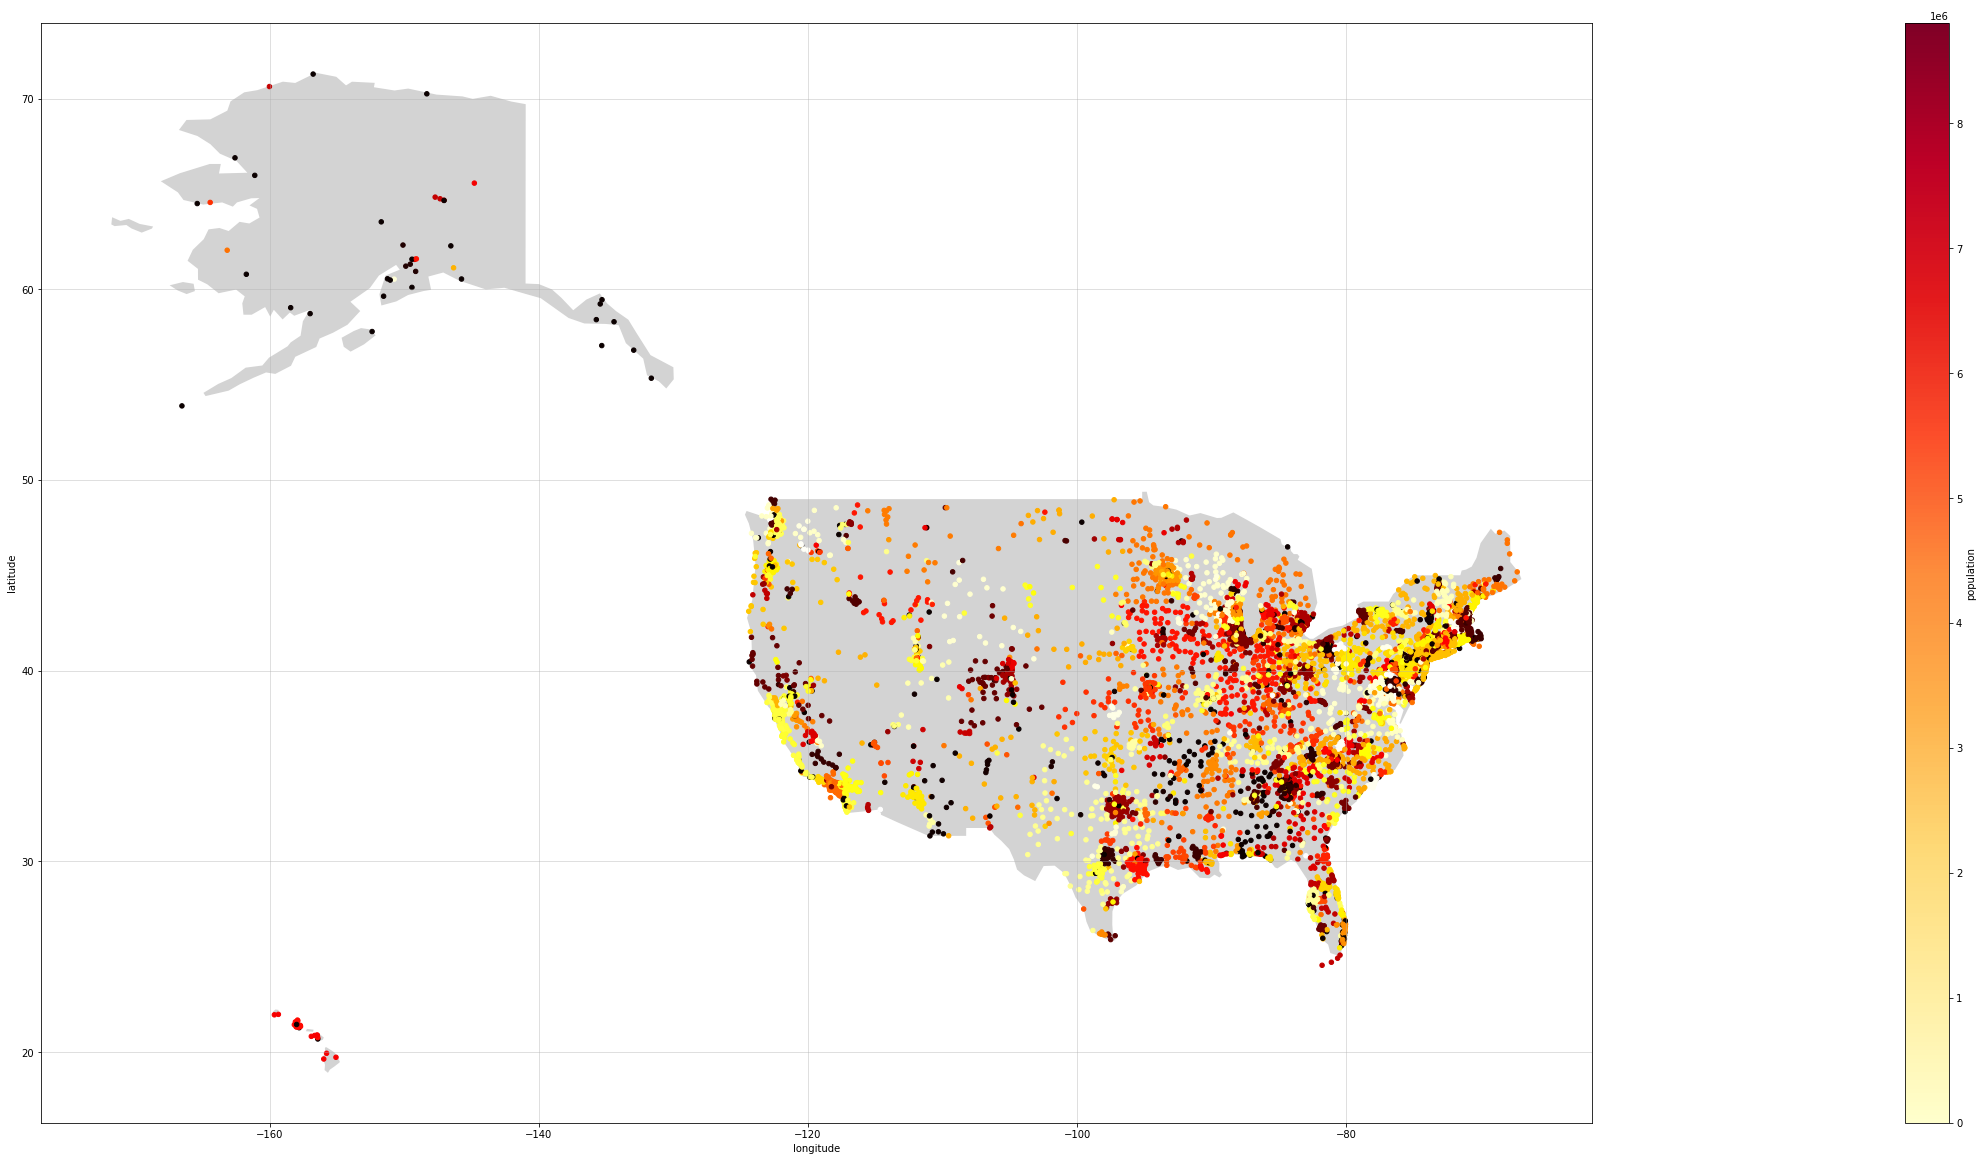

In [ ]:
# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries[countries["name"] == "United States of America"].plot(color="lightgrey", ax=ax)

# plot points
df_us.plot(x="longitude", y="latitude", kind="scatter", c="categorical_msa_codes", colormap="hot", 
        title= " ", ax=ax, colorbar=False, figsize=(40,60))

# define colorbar values
norm = mpl.colors.Normalize(vmin=df_us["population"].min(), vmax=df_us["population"].max())

# set colorbar on ax
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=-0.15)
mpl.colorbar.ColorbarBase(cax, cmap=mpl.cm.YlOrRd, norm=norm, label="population")

# add grid
ax.grid(b=True, alpha=0.5)

plt.show()

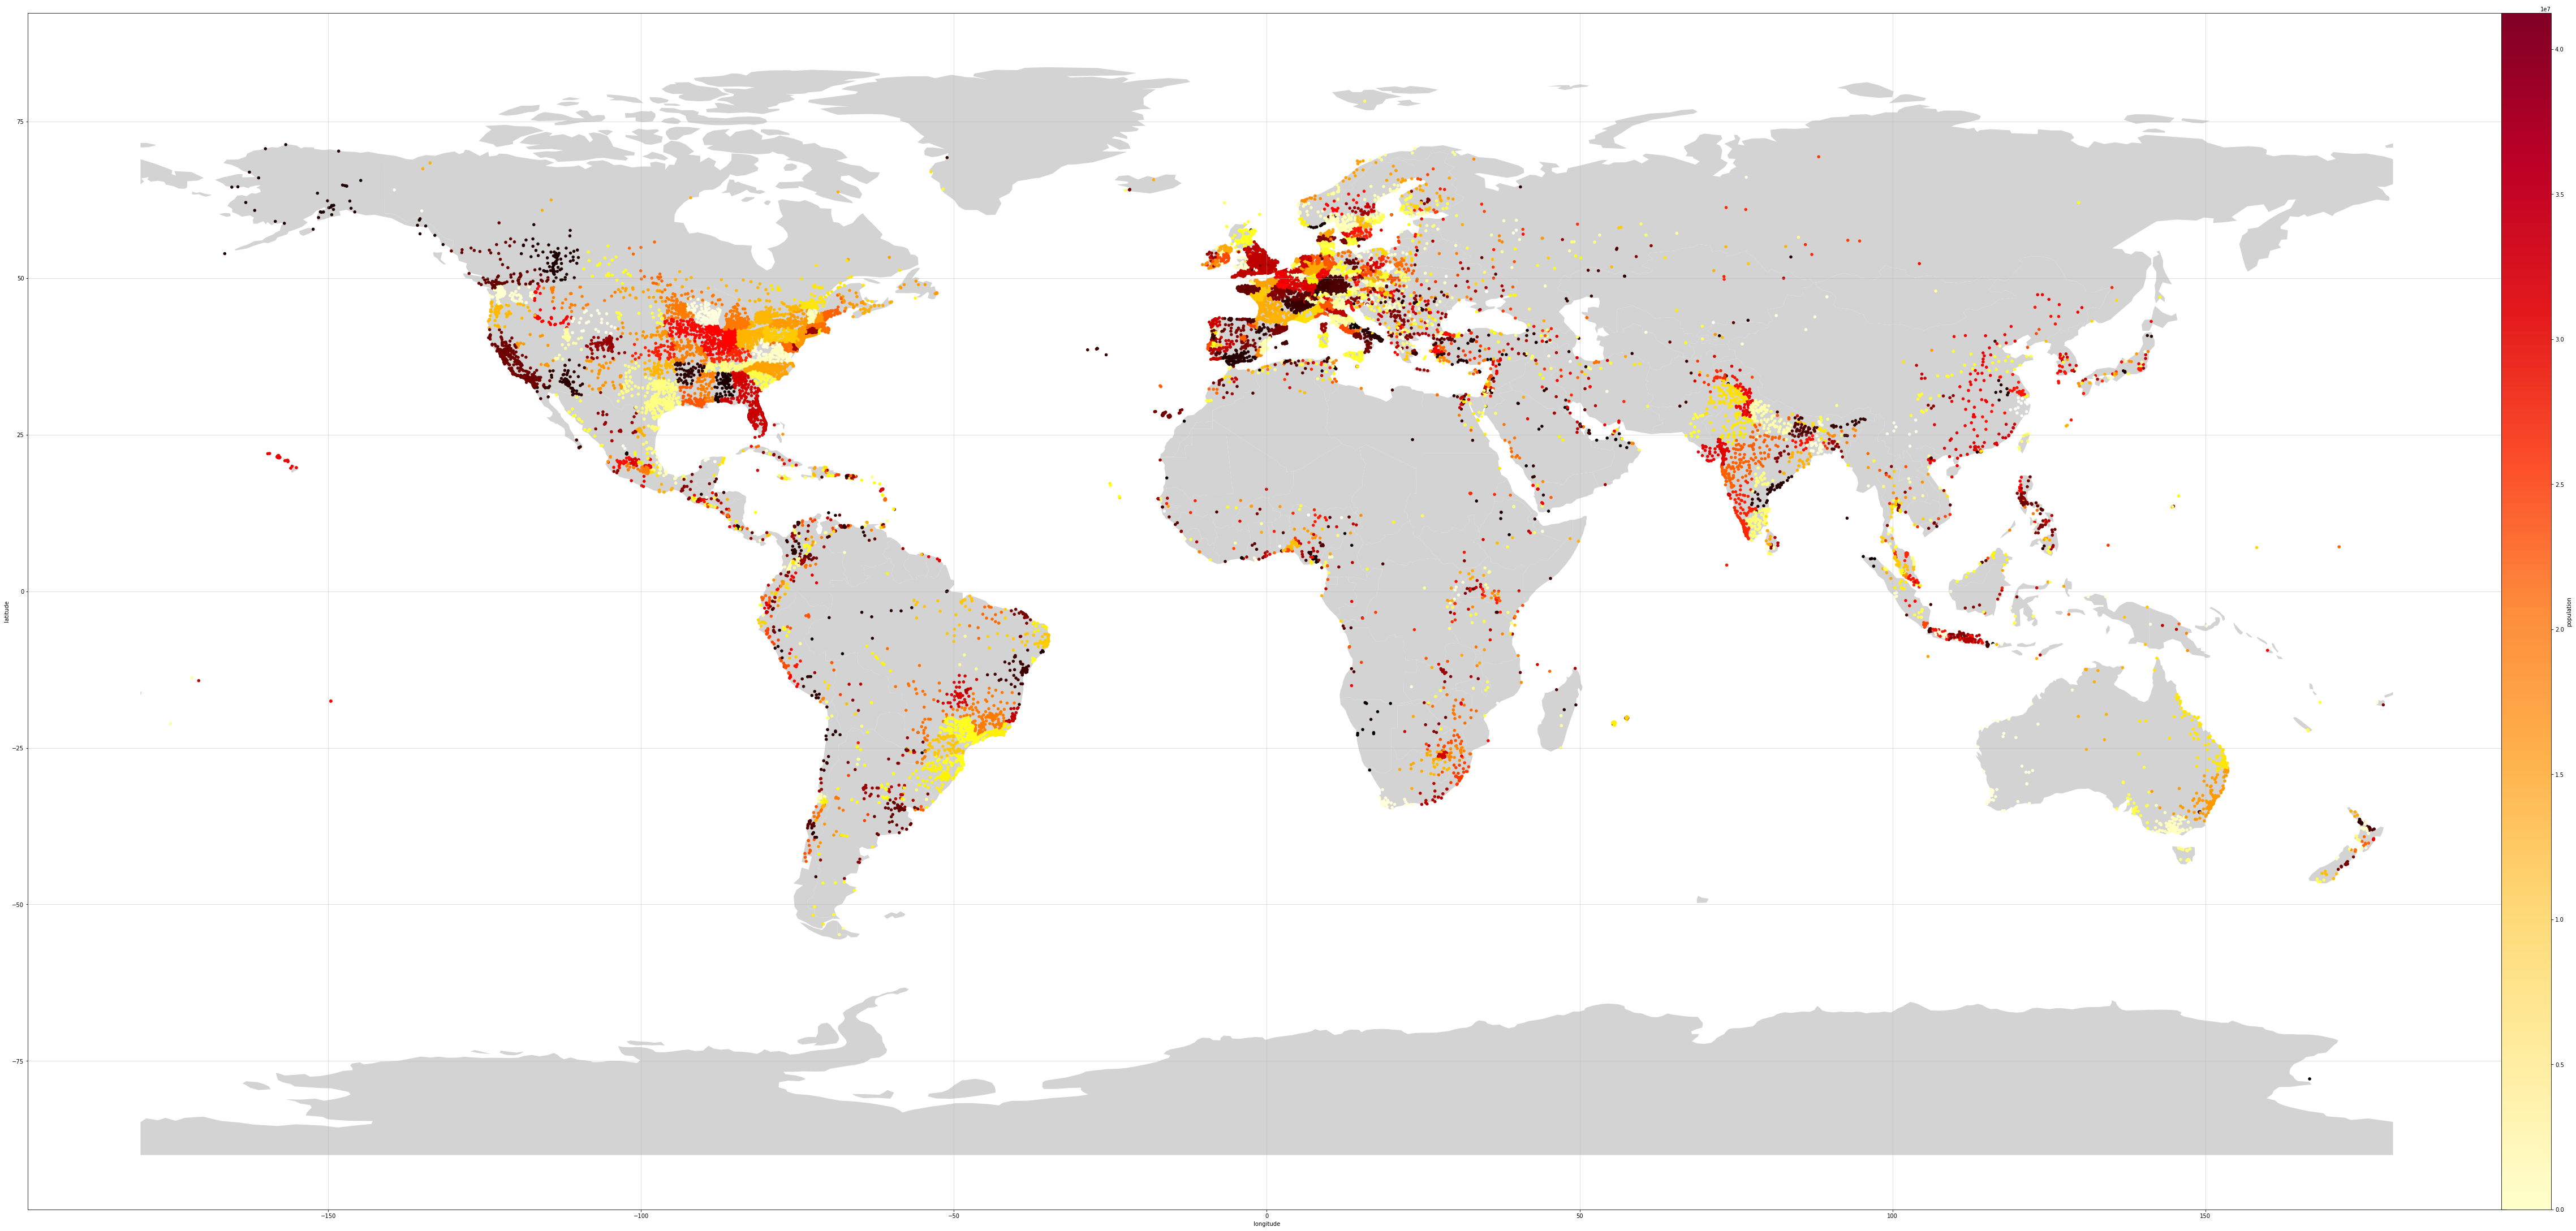

In [ ]:
# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey", ax=ax)

# plot points
df.plot(x="longitude", y="latitude", kind="scatter", c="categorical_state", colormap="hot", 
        title= " ", ax=ax, colorbar=False, figsize=(80,120))

# define colorbar values
norm = mpl.colors.Normalize(vmin=df["population"].min(), vmax=df["population"].max())

# set colorbar on ax
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=-0.15)
mpl.colorbar.ColorbarBase(cax, cmap=mpl.cm.YlOrRd, norm=norm, label="population")

# add grid
ax.grid(b=True, alpha=0.5)

plt.show()

## Observing Turkey as an outside of the US example case for distribution of population and cities

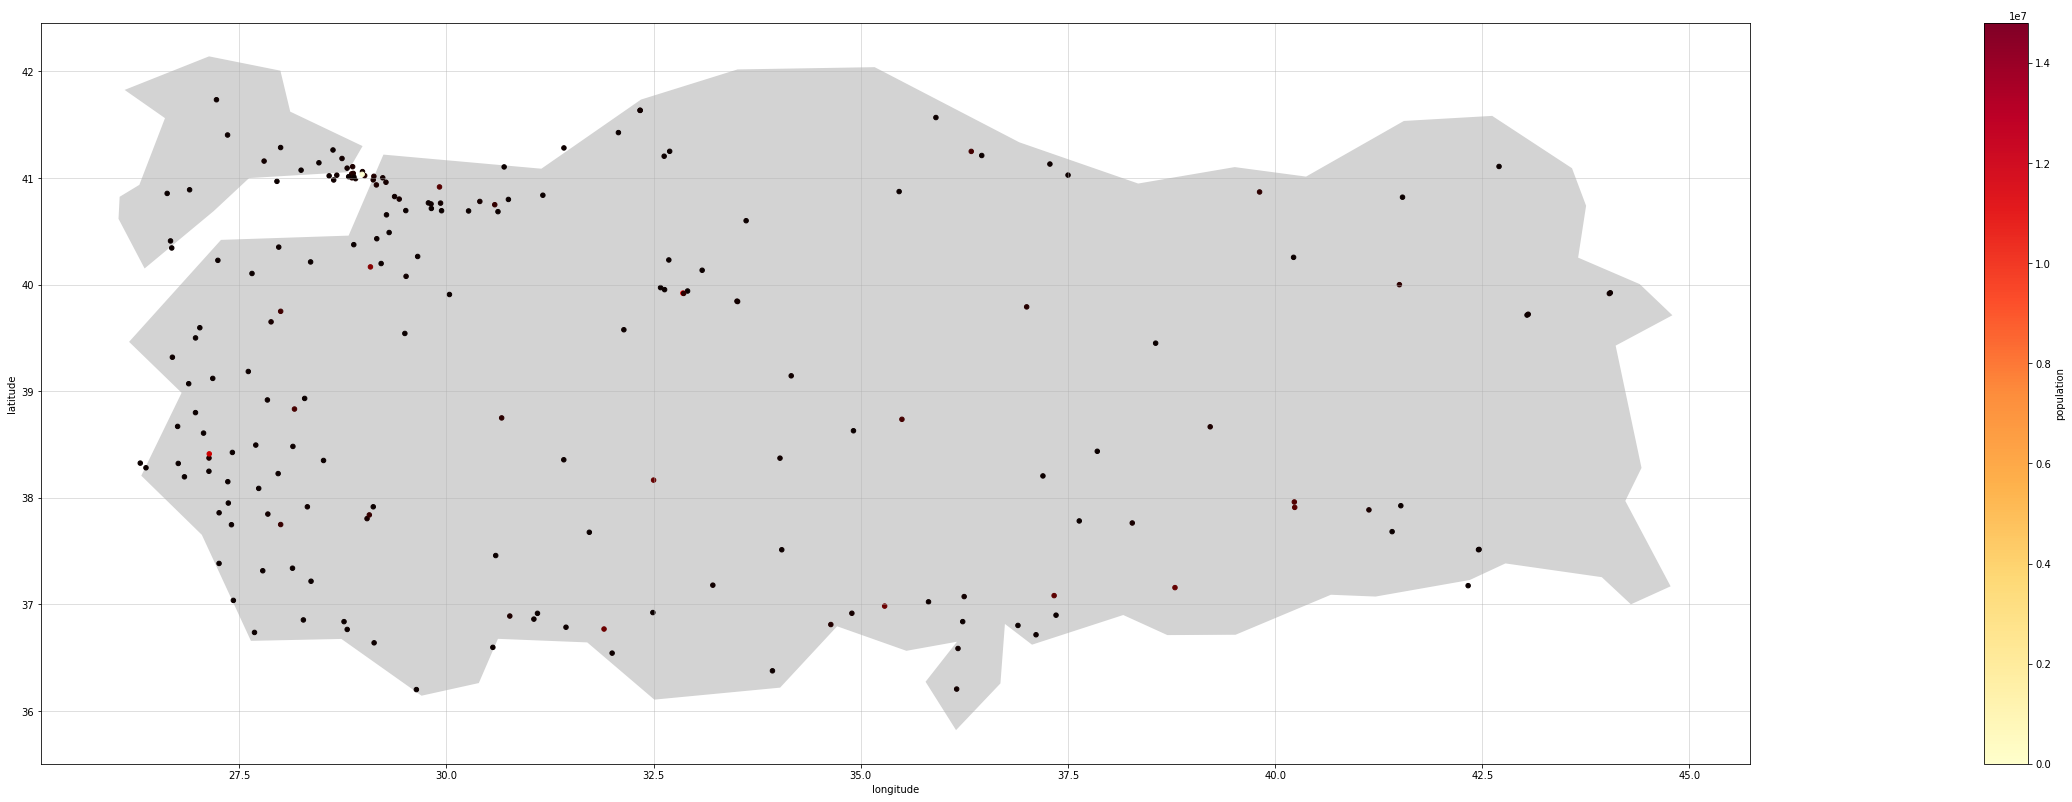

In [ ]:
# initialize an axis
fig, ax = plt.subplots(figsize=(8,6))

# plot map on axis
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries[countries["name"] == "Turkey"].plot(color="lightgrey", ax=ax)

# plot points
df_tr.plot(x="longitude", y="latitude", kind="scatter", c="population", colormap="hot", 
        title= " ", ax=ax, colorbar=False, figsize=(40,60))

# define colorbar values
norm = mpl.colors.Normalize(vmin=df_tr["population"].min(), vmax=df_tr["population"].max())

# set colorbar on ax
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=-0.15)
mpl.colorbar.ColorbarBase(cax, cmap=mpl.cm.YlOrRd, norm=norm, label="population")

# add grid
ax.grid(b=True, alpha=0.5)

plt.show()

In [ ]:
#sns.displot(data=df, x="population", binwidth=100000, height = 20, aspect = 2)

## Visualizing NY MSA

In [ ]:
df_ny_state

city     state        country  latitude  longitude  \
0             mahopac  new york  united states  41.37232  -73.73346   
71        warrensburg  new york  united states  43.49674  -73.77623   
94          thornwood  new york  united states  41.12343  -73.77902   
128           menands  new york  united states  42.69202  -73.72456   
214             marcy  new york  united states  43.17320  -75.26620   
...               ...       ...            ...       ...        ...   
24404       southeast  new york  united states  41.40320  -73.59850   
24553         liberty  new york  united states  41.80120  -74.74655   
25008          alfred  new york  united states  42.25424  -77.79055   
25095     port jervis  new york  united states  41.37509  -74.69266   
25373  northumberland  new york  united states  43.12730  -73.58817   

       population                                                msa  \
0            8369  New York-Northern New Jersey-Long Island NY-NJ...   
71           3103                                 Glens Falls NY MSA   
94           3759  New York-Northern New Jersey-Long Island NY-NJ...   
128          3998                                                NaN   
214          9465                                  Utica-Rome NY MSA   
...           ...                                                ...   
24404       18153                                                NaN   
24553        4134                            NY NONMETROPOLITAN AREA   
25008        4061                            NY NONMETROPOLITAN AREA   
25095        8609            Poughkeepsie-Newburgh-Middletown NY MSA   
25373        5159                            PA NONMETROPOLITAN AREA   

                                         categorical_msa  \
0      New York-Northern New Jersey-Long Island NY-NJ...   
71                                    Glens Falls NY MSA   
94     New York-Northern New Jersey-Long Island NY-NJ...   
128                                                  NaN   
214                                    Utica-Rome NY MSA   
...                                                  ...   
24404                                                NaN   
24553                            NY NONMETROPOLITAN AREA   
25008                            NY NONMETROPOLITAN AREA   
25095            Poughkeepsie-Newburgh-Middletown NY MSA   
25373                            PA NONMETROPOLITAN AREA   

       categorical_msa_codes  
0                        265  
71                       132  
94                       265  
128                       -1  
214                      377  
...                      ...  
24404                     -1  
24553                    259  
25008                    259  
25095                    299  
25373                    282  

[508 rows x 9 columns]

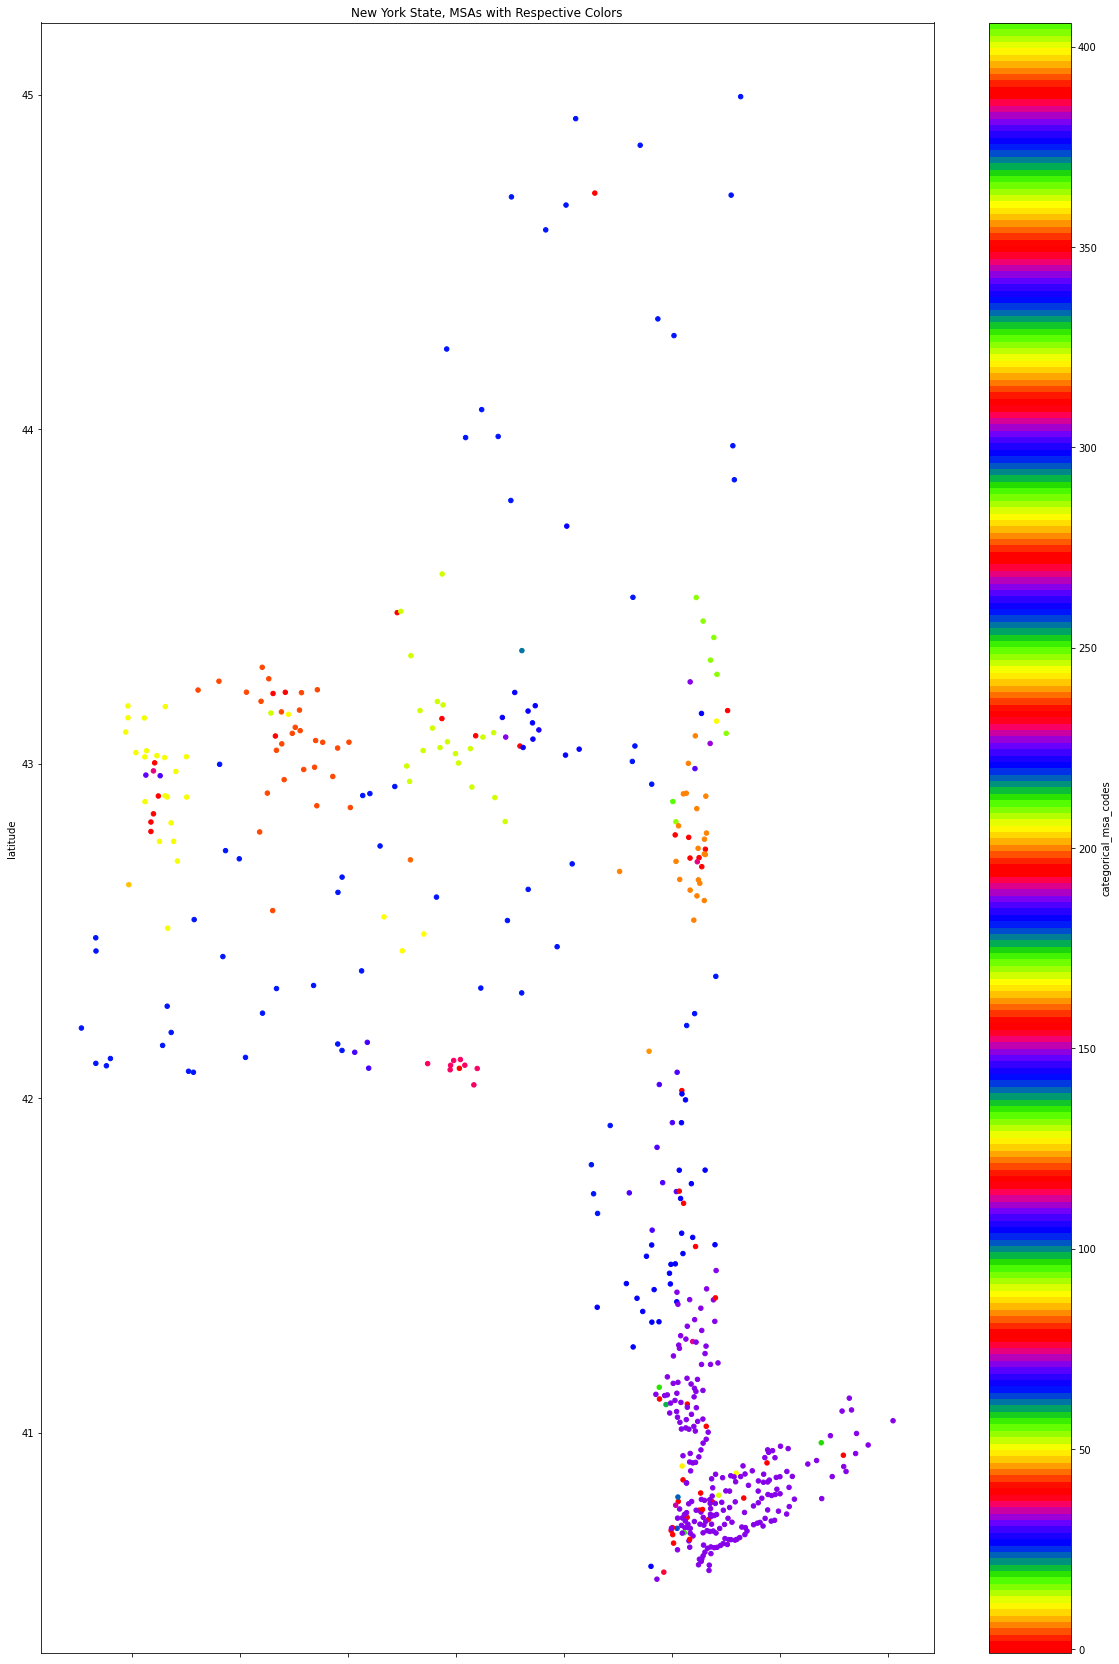

In [ ]:
df_ny_state.plot(x="longitude", y="latitude", kind="scatter", c="categorical_msa_codes", colormap="prism", 
        title= "New York State, MSAs with Respective Colors", colorbar=True, figsize=(20,30))
plt.show()

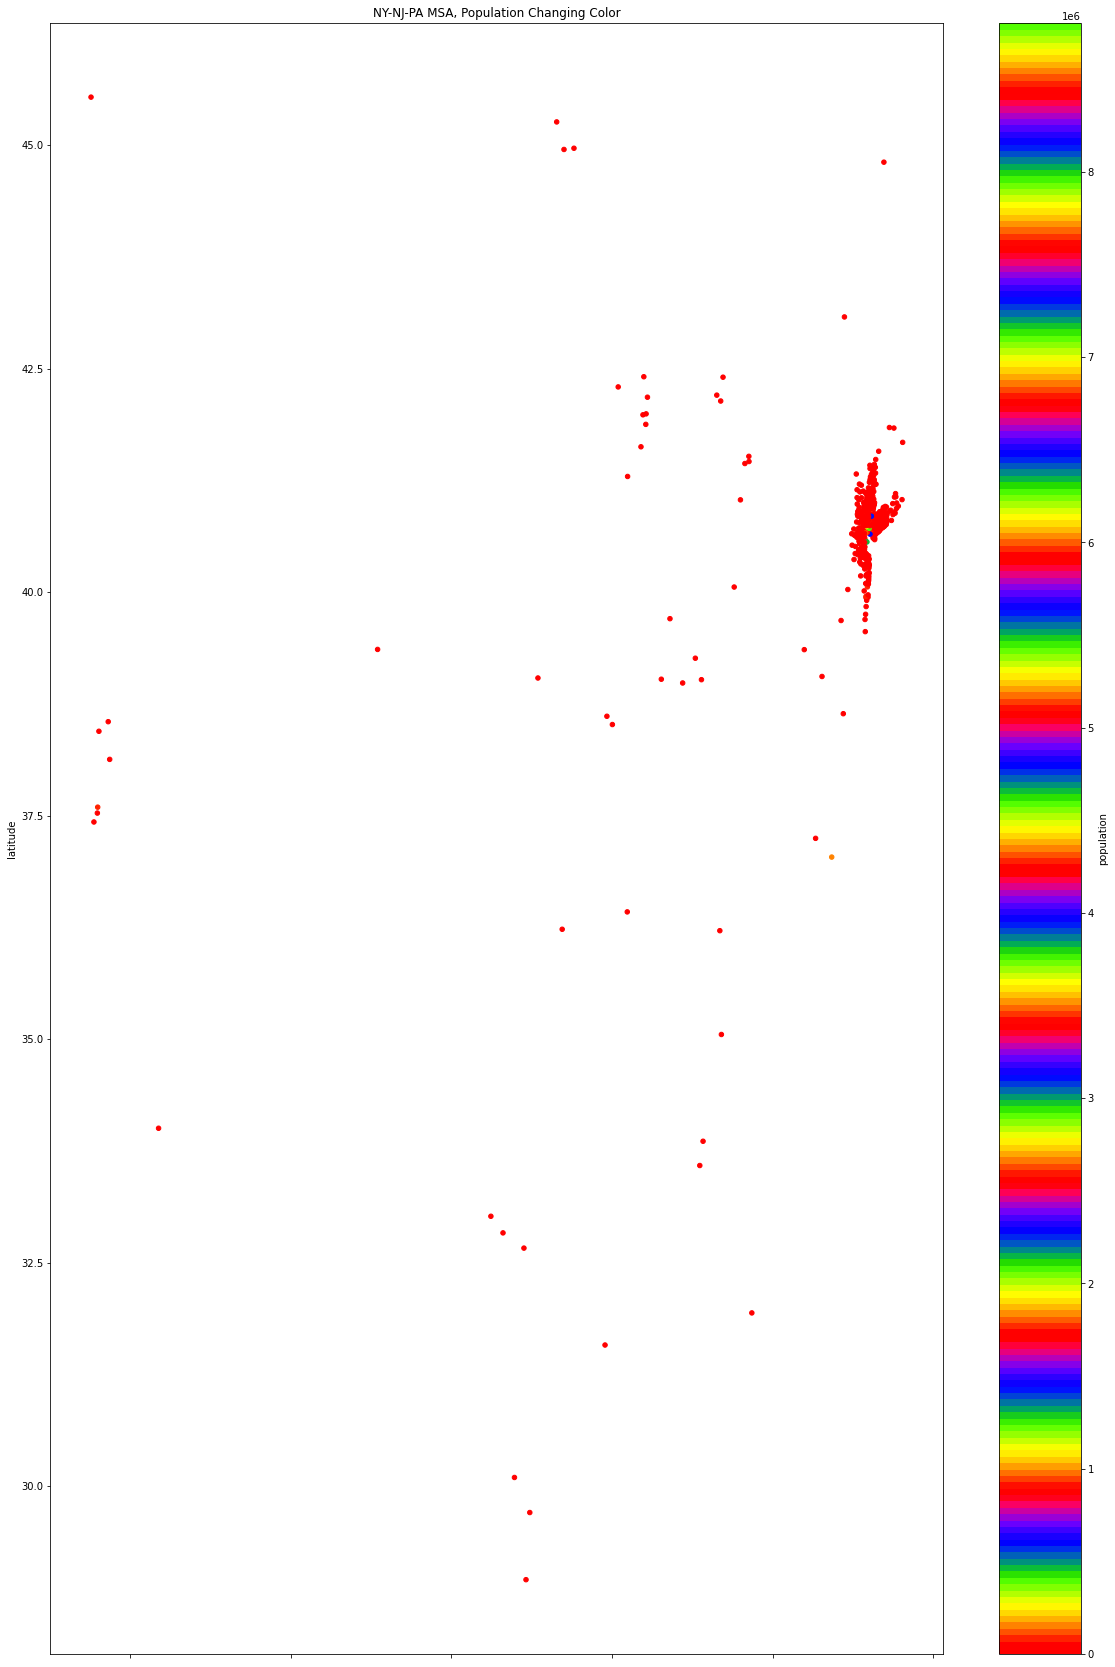

In [ ]:
df_ny.plot(x="longitude", y="latitude", kind="scatter", c="population", colormap="prism", 
        title= "NY-NJ-PA MSA, Population Changing Color", colorbar=True, figsize=(20,30))
plt.show()

### Results show that, in NY-NJ-PA MSA, the scale of the MSA is quite large and this represents an area economiccally connected. While, there can be observed a large variability within this area in terms of living costs, lifestyle and job opportunities. It can be also stated that commuting between regions in this scale is not probable in a comprehensive way. 


## In order to improve MSA based segmentation, density based clustering will be implemented. It's crucial that some cities may not be a part of any MSAs, and outliers in density based method allows leaving outliers outside of the clusters.


In [14]:
# import DBSCAN
from sklearn.cluster import DBSCAN

# Only Focusing the NY State area as an initial observation & hyperparameter selection
db = DBSCAN(eps=200, min_samples=5)
db.fit(df_ny_state[["latitude", "longitude", "population"]])


DBSCAN(eps=200)

### In the scope of Density Based Clustering, DBSCAN is a reliable methodology due to its ability to identify arbitrarily shaped areas, hyperparameter optimization to manage cluster sizes for different needs of the customers, as well as the ability to separate outliers. The main challenge is, while proximity is useful in the scope of coordinates, proximity of population of neighboring areas is subjective. For example, even though two cities have a high population and close proximity, they may be seperate hubs and we might need to showcase this in our results.

In [ ]:
y_pred = db.fit_predict(df_ny_state[["latitude", "longitude", "population"]])
df_ny_state["dbscan_labels"] = y_pred


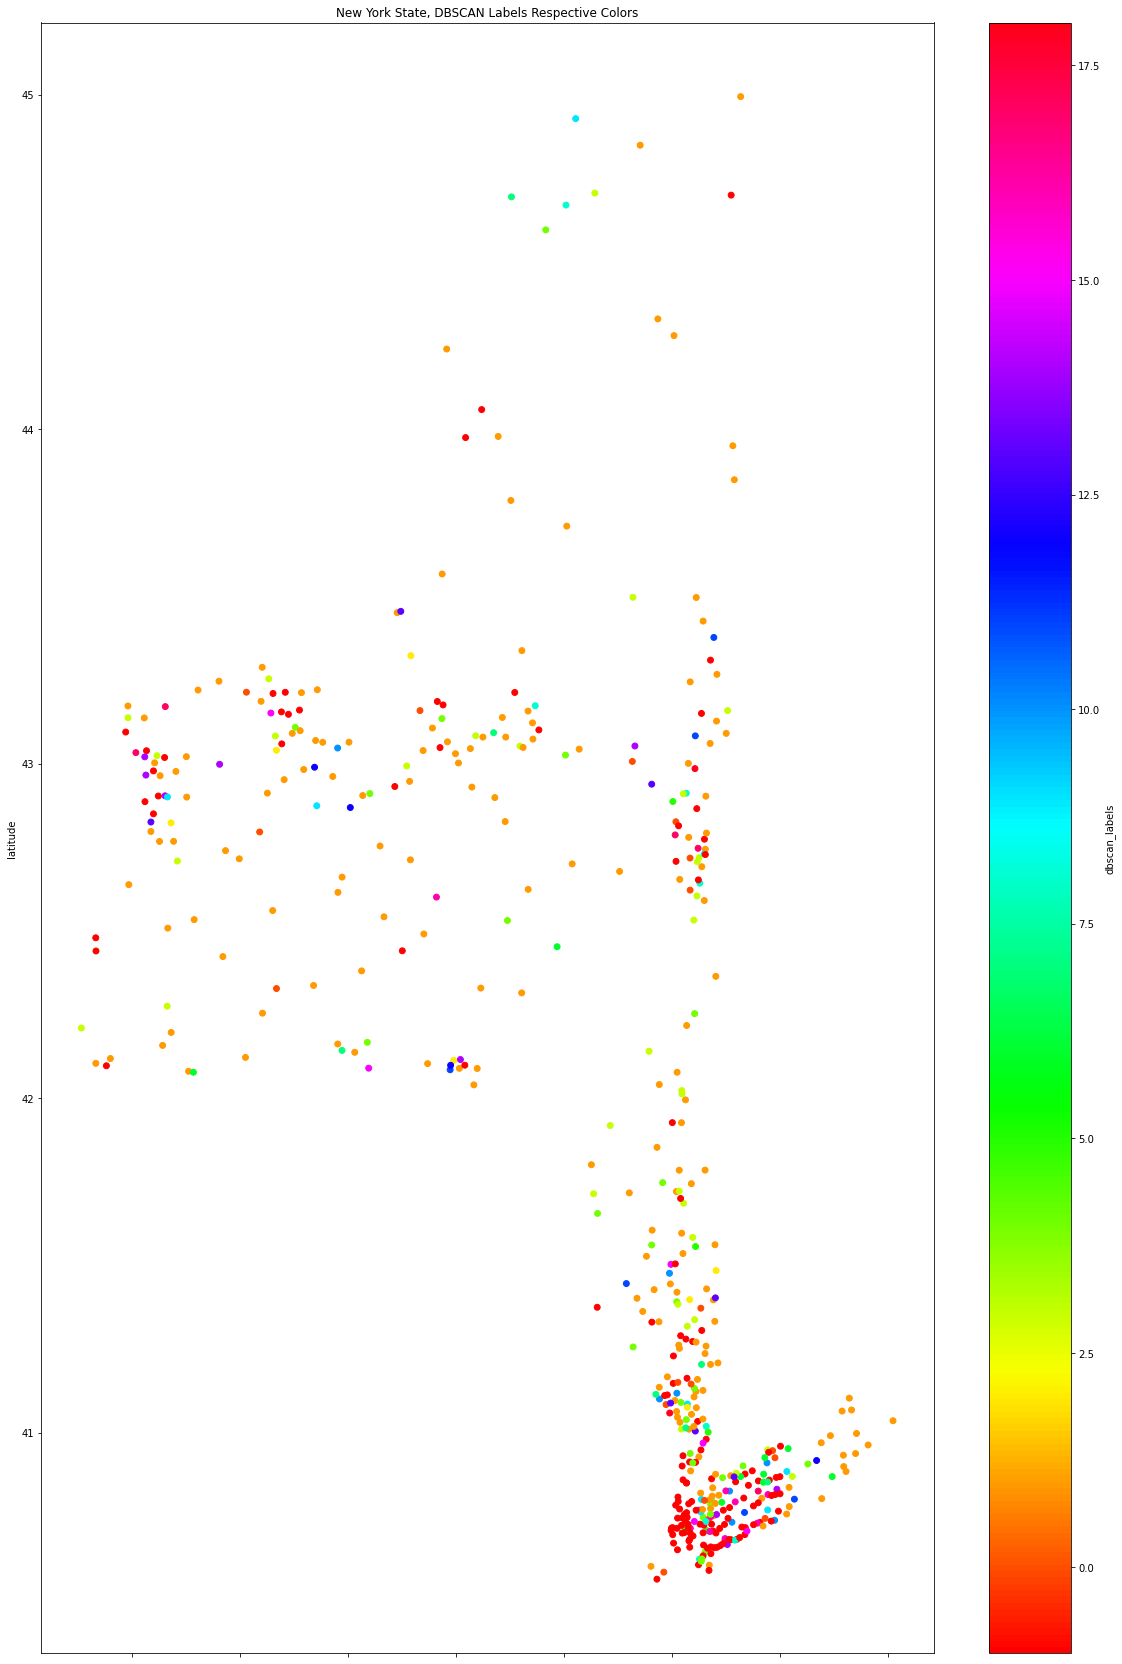

In [ ]:
df_ny_state.plot(x="longitude", y="latitude", kind="scatter", c="dbscan_labels", s=35, colormap="hsv", 
        title= "New York State, DBSCAN Labels Respective Colors", colorbar=True, figsize=(20,30))
plt.show()


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'DBSCAN Labels')

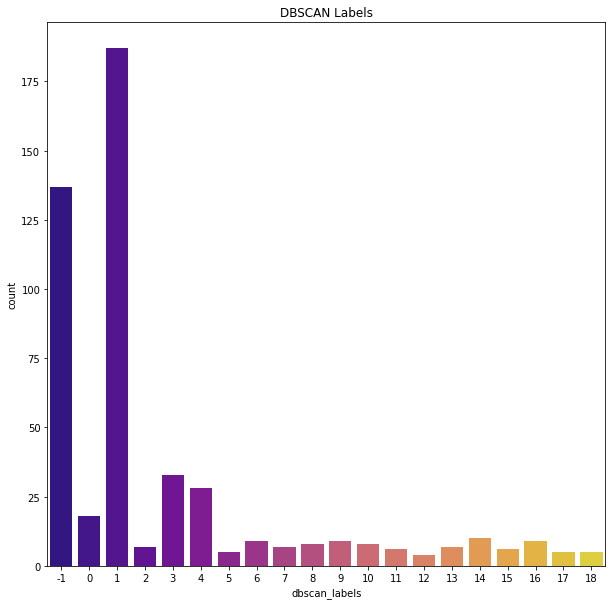

In [ ]:
sns.countplot(df_ny_state["dbscan_labels"], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('DBSCAN Labels')

## Results show that a high number of outliers occur, also population metric is not quite meaningful in the context of clustering and Euclidean Distance. The reason for that is, a low population city near a high population city has a potential to be clustered together since high population city acts as a hub for the small population city for many aspects, the most basic ones can be airport access, healthcare facilities or educational institutes. While, Euclidean Distance does not reflect that and high population difference leads to separate clusters for these cities.

## To prevent this, a new feature will be engineered based on population. For each state in the dataset, their population distribution will be extracted. For each city, based on their positioning in the percentile distribution of their respective state, they will be assigned a label. For example, 0-25% will be "1", 25-50% will be "2", 50-75% will be "3", 75-100% will be "4". 

## In order to cluster cities with large difference in population in the same cluster if they are in close proximity, 1 and 4 values will be grouped together and 2,3 values will be grouped together. So, for the case of two cities where one has a large population and one has a small population but they are very close to one anothet in terms of coordinates, the algorithm will be likely to cluster them together due to additional proximity in their population labels.

In [ ]:
#df_us.drop(columns=["bins"], inplace = True)
df_us.drop(columns=["bins_coded"], inplace = True)
df_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7484 entries, 0 to 25409
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   city                   7484 non-null   object  
 1   state                  7484 non-null   object  
 2   country                7484 non-null   object  
 3   latitude               7484 non-null   float64 
 4   longitude              7484 non-null   float64 
 5   population             7484 non-null   int64   
 6   msa                    6941 non-null   object  
 7   categorical_msa        6941 non-null   category
 8   categorical_msa_codes  7484 non-null   int16   
 9   bins                   7484 non-null   category
dtypes: category(2), float64(2), int16(1), int64(1), object(4)
memory usage: 781.8+ KB


In [ ]:
df_us["bins"] = df_us.groupby("state")["population"].apply(lambda x: 
                                                               pd.cut(x, 
                                                                      bins = [0,25000,50000, 100000, 250000, 500000, max(df_us["population"])],
                                                                      labels = [0,10,20,20,10,0], ordered =  False, include_lowest = True,
                                                                                 duplicates='drop'))

#[0,10000,50000,100000, max(df_us["population"])]
#labels = ["Q1", "Q2", "Q3"],

In [ ]:
df_us["bins"]

0         0
1         0
2         0
6         0
13        0
         ..
25405    20
25406     0
25407     0
25408     0
25409    10
Name: bins, Length: 7484, dtype: category
Categories (3, int64): [0, 10, 20]

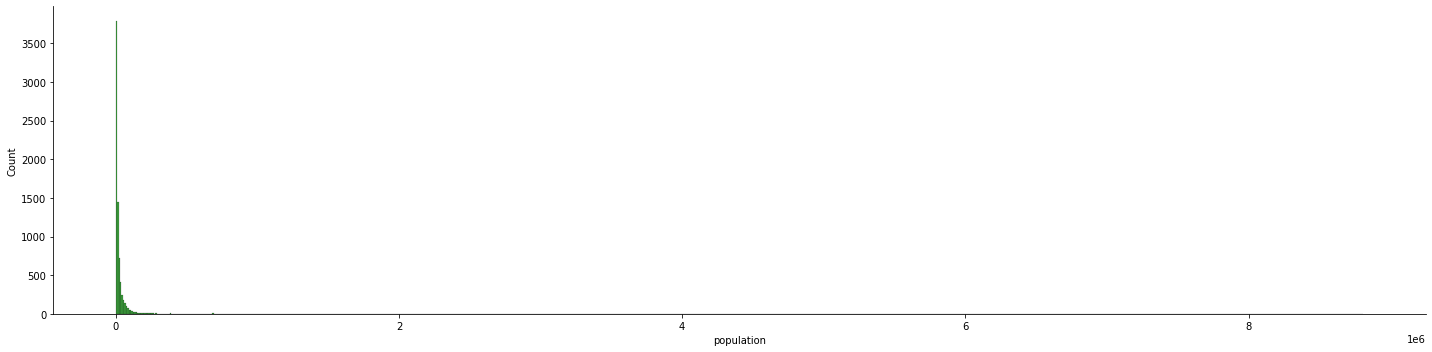

In [ ]:
sns.displot(data=df_us, x="population", binwidth=10000, height = 5, aspect = 4, color = "green")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Bins for US Cities Based on Population')

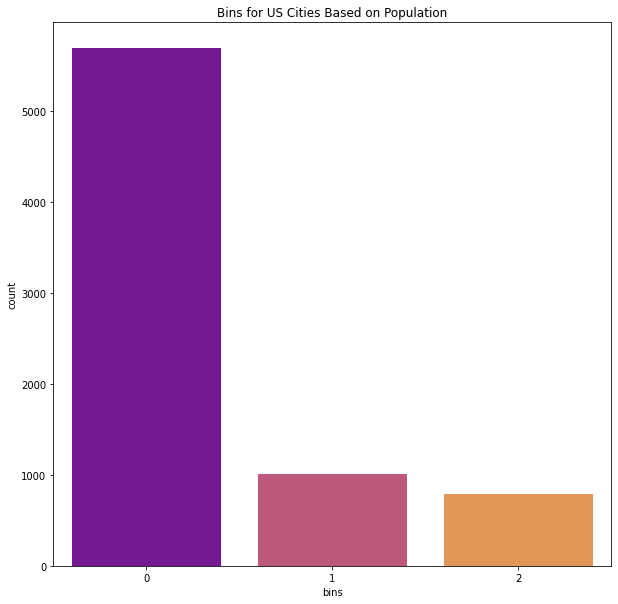

In [ ]:
sns.countplot(df_us["bins"], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title("Bins for US Cities Based on Population")

### Results show that, when population is binned through 0-10.000,10.000-100.000, 100.000+ bins, we have two similar groups and one less observed group. Q1 and Q2 represent first and second bins, Q3 represents the largest bin within each state. 

### The assumption is, cities within close geographical proximity can be clustered together if their population is significantly different. This relies on the research that small cities can be connected/dependent to larger cities near them for certain activities. With the help of DBSCAN's hyperparameter optimization, we can design the granularity of these clusters to find optimal segmentation.

### The next step is to merge Q1 and Q5, so that algorithm will recognize them as similar, and separate Q2,Q3.

In [64]:
df_us["bins"] = df_us.groupby("state")["population"].apply(lambda x: 
                                                               pd.cut(x, 
                                                                      bins = [0,25000,50000, 100000, 250000, 500000, max(df_us["population"])],
                                                                      labels = [0,1,2,2,1,0], ordered =  False, include_lowest = True,
                                                                                 duplicates='drop'))

#[0,10000,50000,100000, max(df_us["population"])]
#labels = ["Q1", "Q2", "Q3"],

In [65]:
# Only Focusing the NY State area as an initial observation & hyperparameter selection
db = DBSCAN(eps=0.5, min_samples=5)
db.fit(df_us[["latitude", "longitude"]]) #, "bins"

DBSCAN()

In [66]:
y_pred = db.fit_predict(df_us[["latitude", "longitude"]]) #, "bins"
df_us["dbscan_labels"] = y_pred

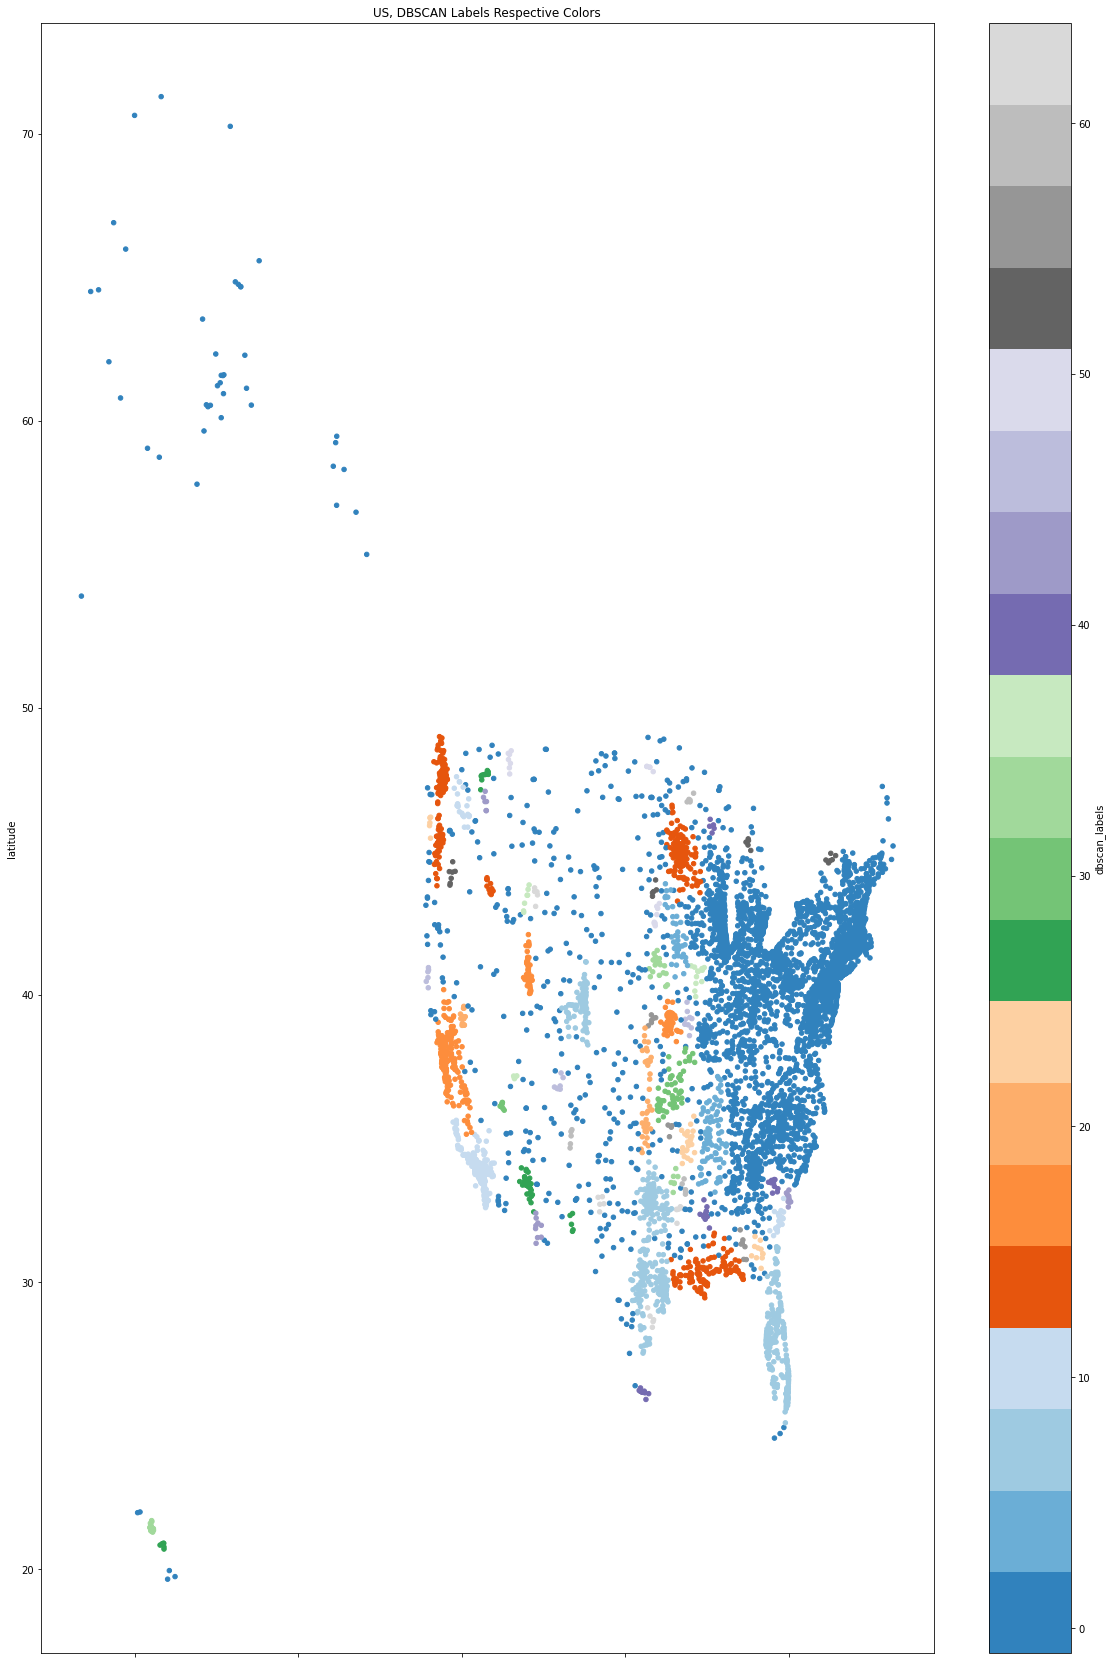

In [ ]:
df_us.plot(x="longitude", y="latitude", kind="scatter", c="dbscan_labels", s=20, colormap="tab20c", 
        title= "US, DBSCAN Labels Respective Colors", colorbar=True, figsize=(20,30))
plt.show()


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'US, DBSCAN Labels')

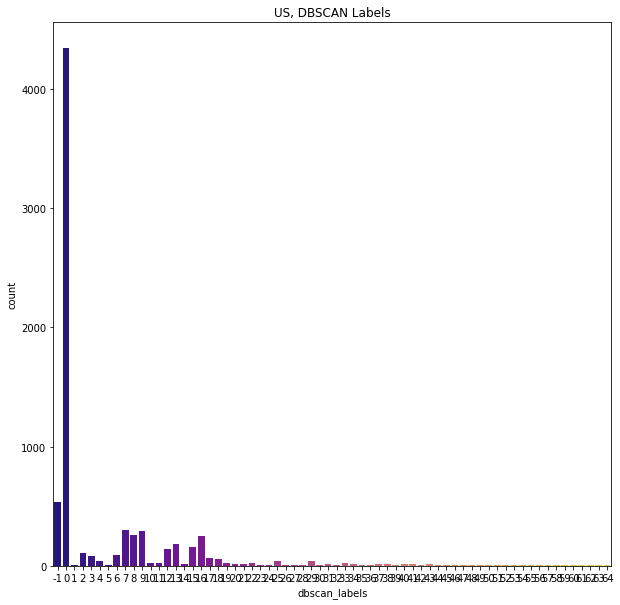

In [67]:
sns.countplot(df_us["dbscan_labels"], palette="plasma")
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.title('US, DBSCAN Labels')

In [ ]:
df_us["dbscan_labels"].value_counts()

 0     4342
-1      538
 7      305
 9      293
 8      261
       ... 
 59       5
 26       5
 23       5
 62       5
 56       4
Name: dbscan_labels, Length: 66, dtype: int64

### DBSCAN methodology provides a major drawback: densities of cities and their spatial dispersion are changing accross US, as well as in between countries. So, to increase robustness against changing densities, OPTICS Clustering Algorithm will be implemented.

### OPTICS Clustering

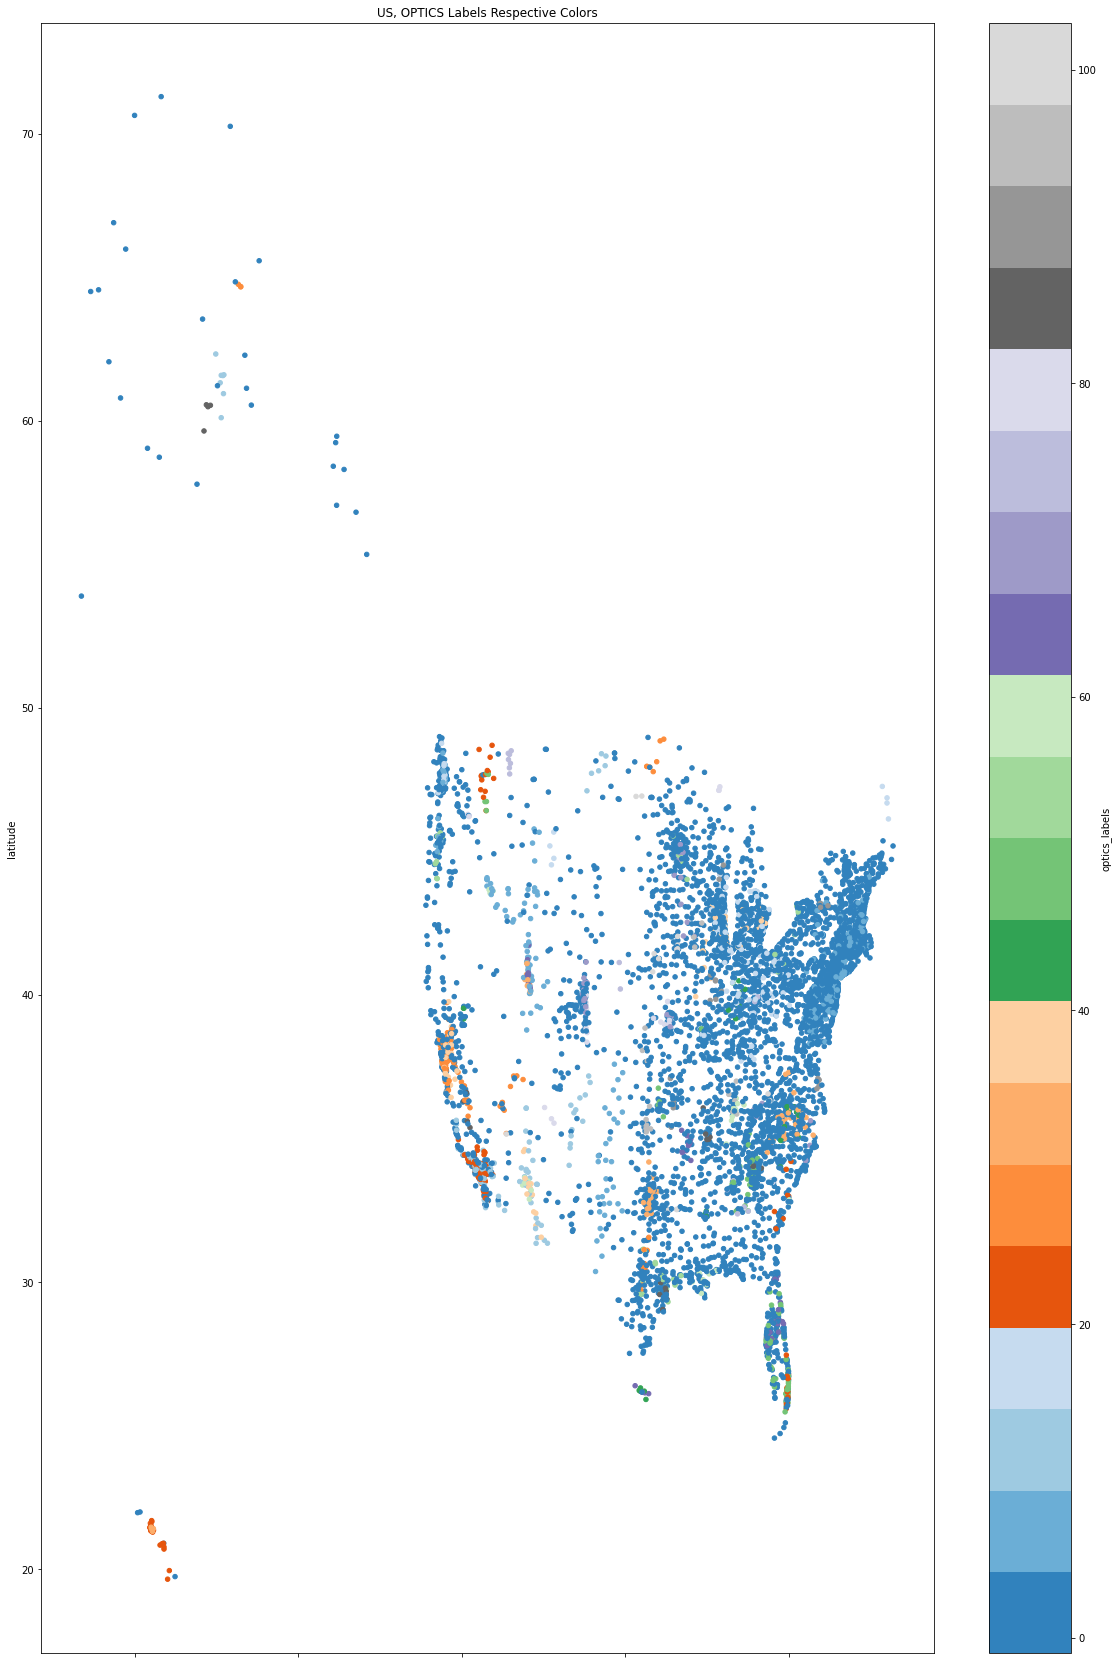

In [ ]:
from sklearn.cluster import OPTICS

opt = OPTICS(max_eps = 1, min_samples=3, cluster_method = "dbscan").fit(df_us[["latitude", "longitude", "bins"]]) #, "bins"
y_pred_optics = opt.labels_
df_us["optics_labels"] = y_pred_optics
df_us.plot(x="longitude", y="latitude", kind="scatter", c="optics_labels", s=20, colormap="tab20c", 
        title= "US, OPTICS Labels Respective Colors", colorbar=True, figsize=(20,30))
plt.show()


## HDBScan

In [ ]:
import hdbscan

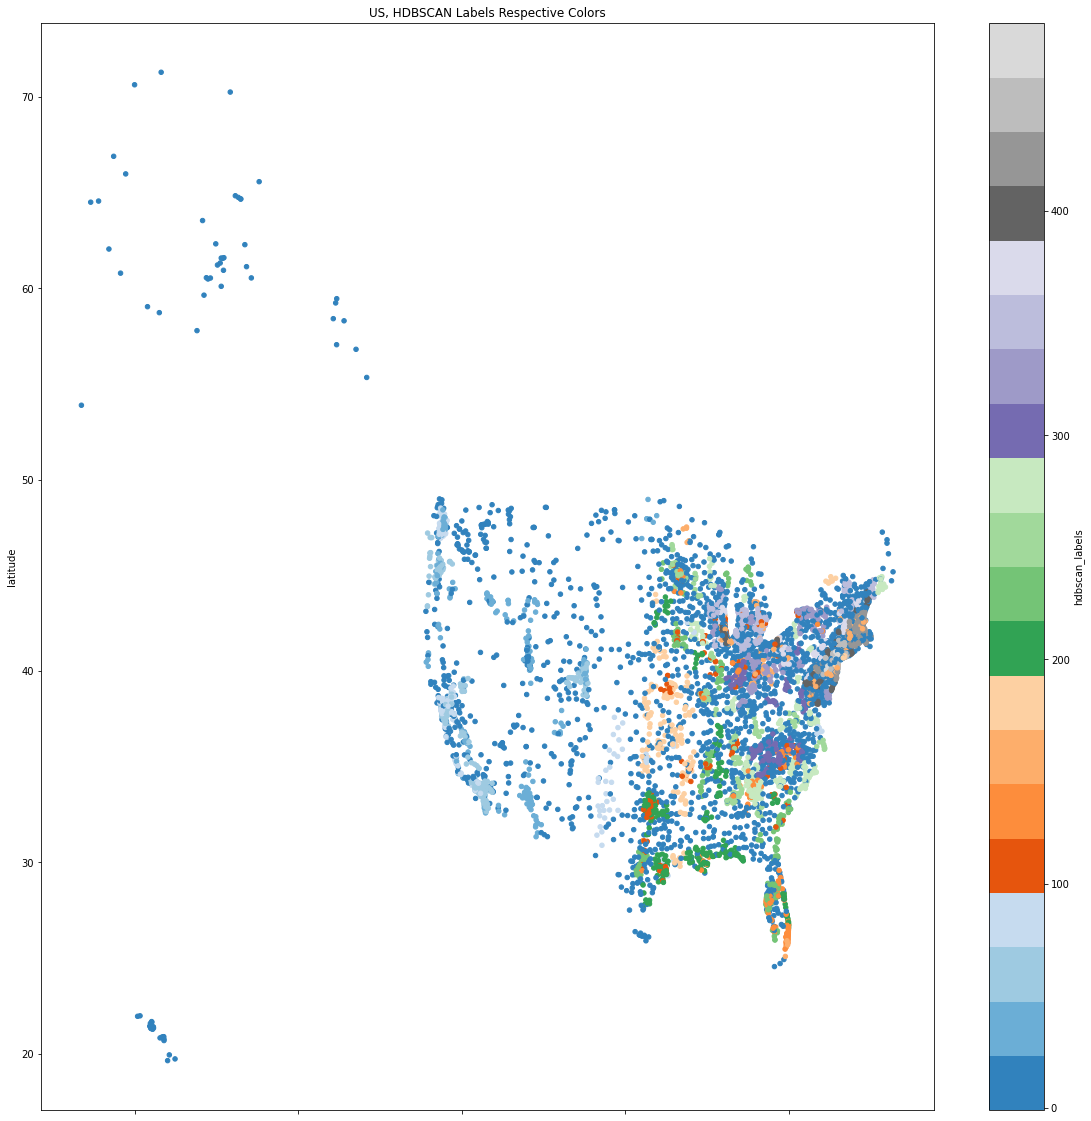

In [68]:
hdb = hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_epsilon = 0.015, gen_min_span_tree=True) #metric='haversine',
hdb.fit(df_us[["latitude", "longitude", "bins"]]) #, "bins"
y_pred = hdb.fit_predict(df_us[["latitude", "longitude", "bins"]]) #, "bins"
df_us["hdbscan_labels"] = y_pred
df_us.plot(x="longitude", y="latitude", kind="scatter", c="hdbscan_labels", s=20, colormap="tab20c", 
        title= "US, HDBSCAN Labels Respective Colors", colorbar=True, figsize=(20,20))
plt.show()


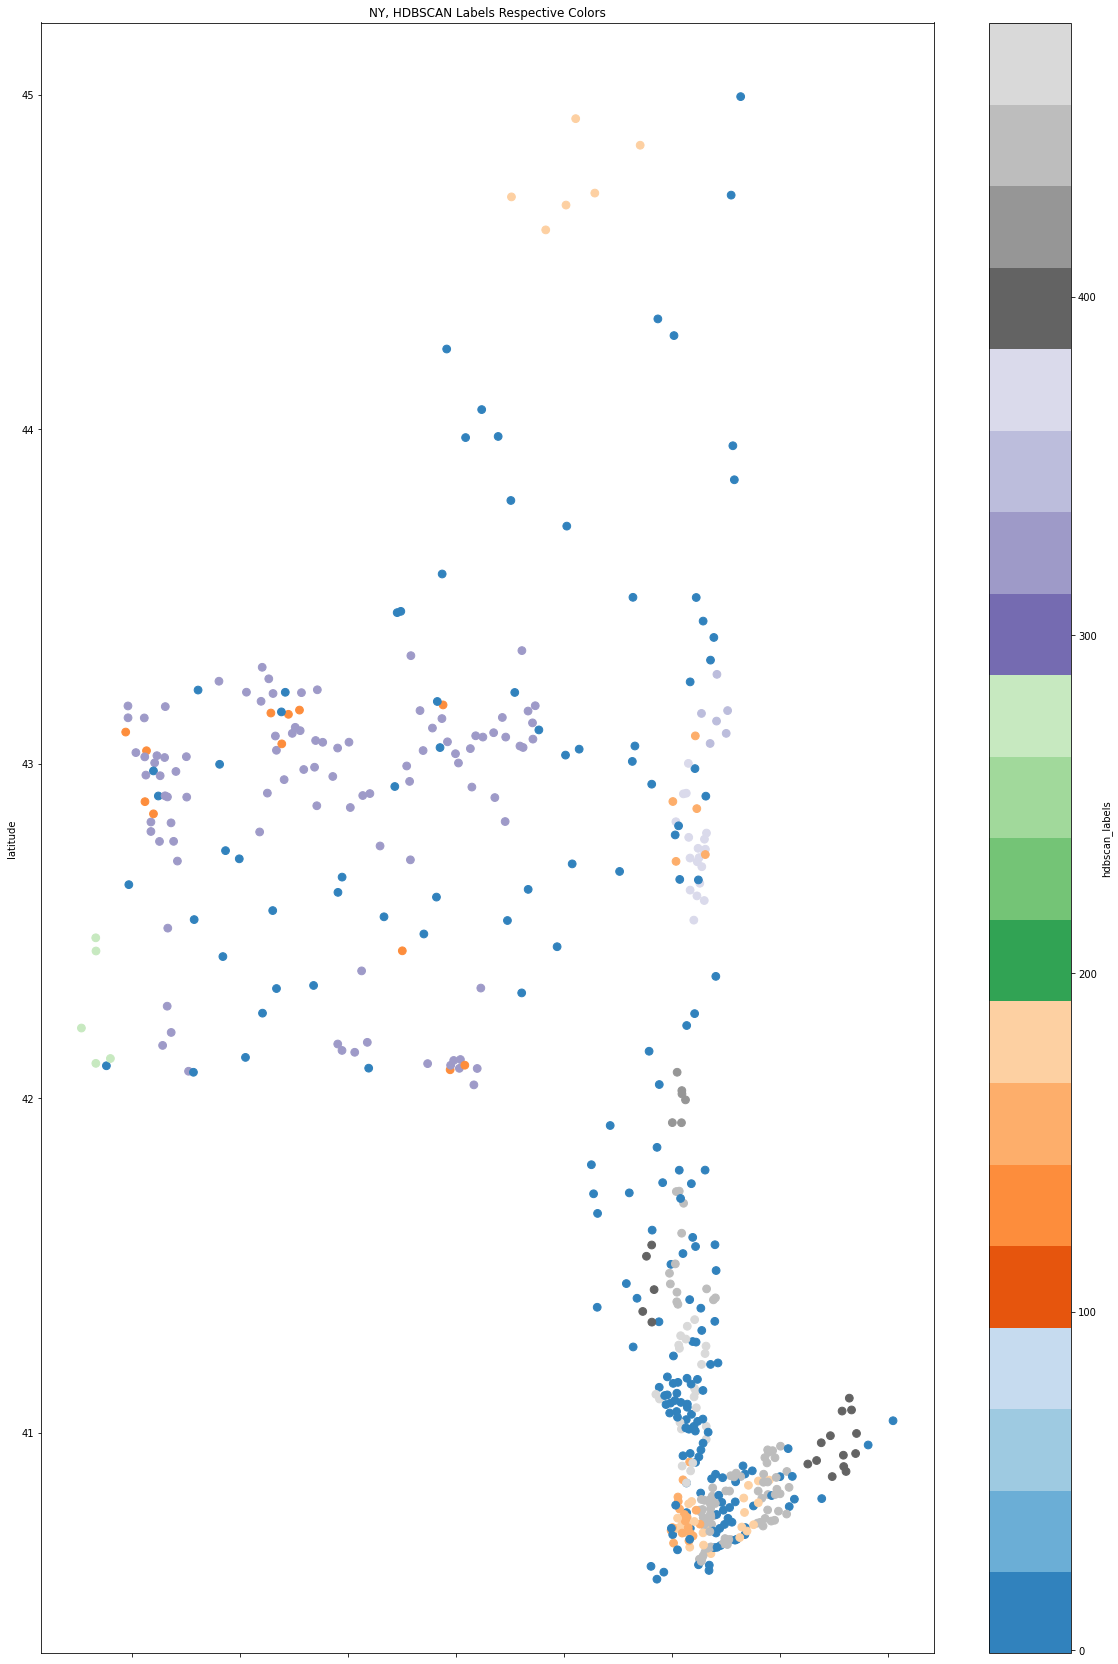

In [69]:
df_us[df_us["state"]=="new york"].plot(x="longitude", y="latitude", kind="scatter", c="hdbscan_labels", s=60, colormap="tab20c", 
        title= "NY, HDBSCAN Labels Respective Colors", colorbar=True, figsize=(20,30))
plt.show()

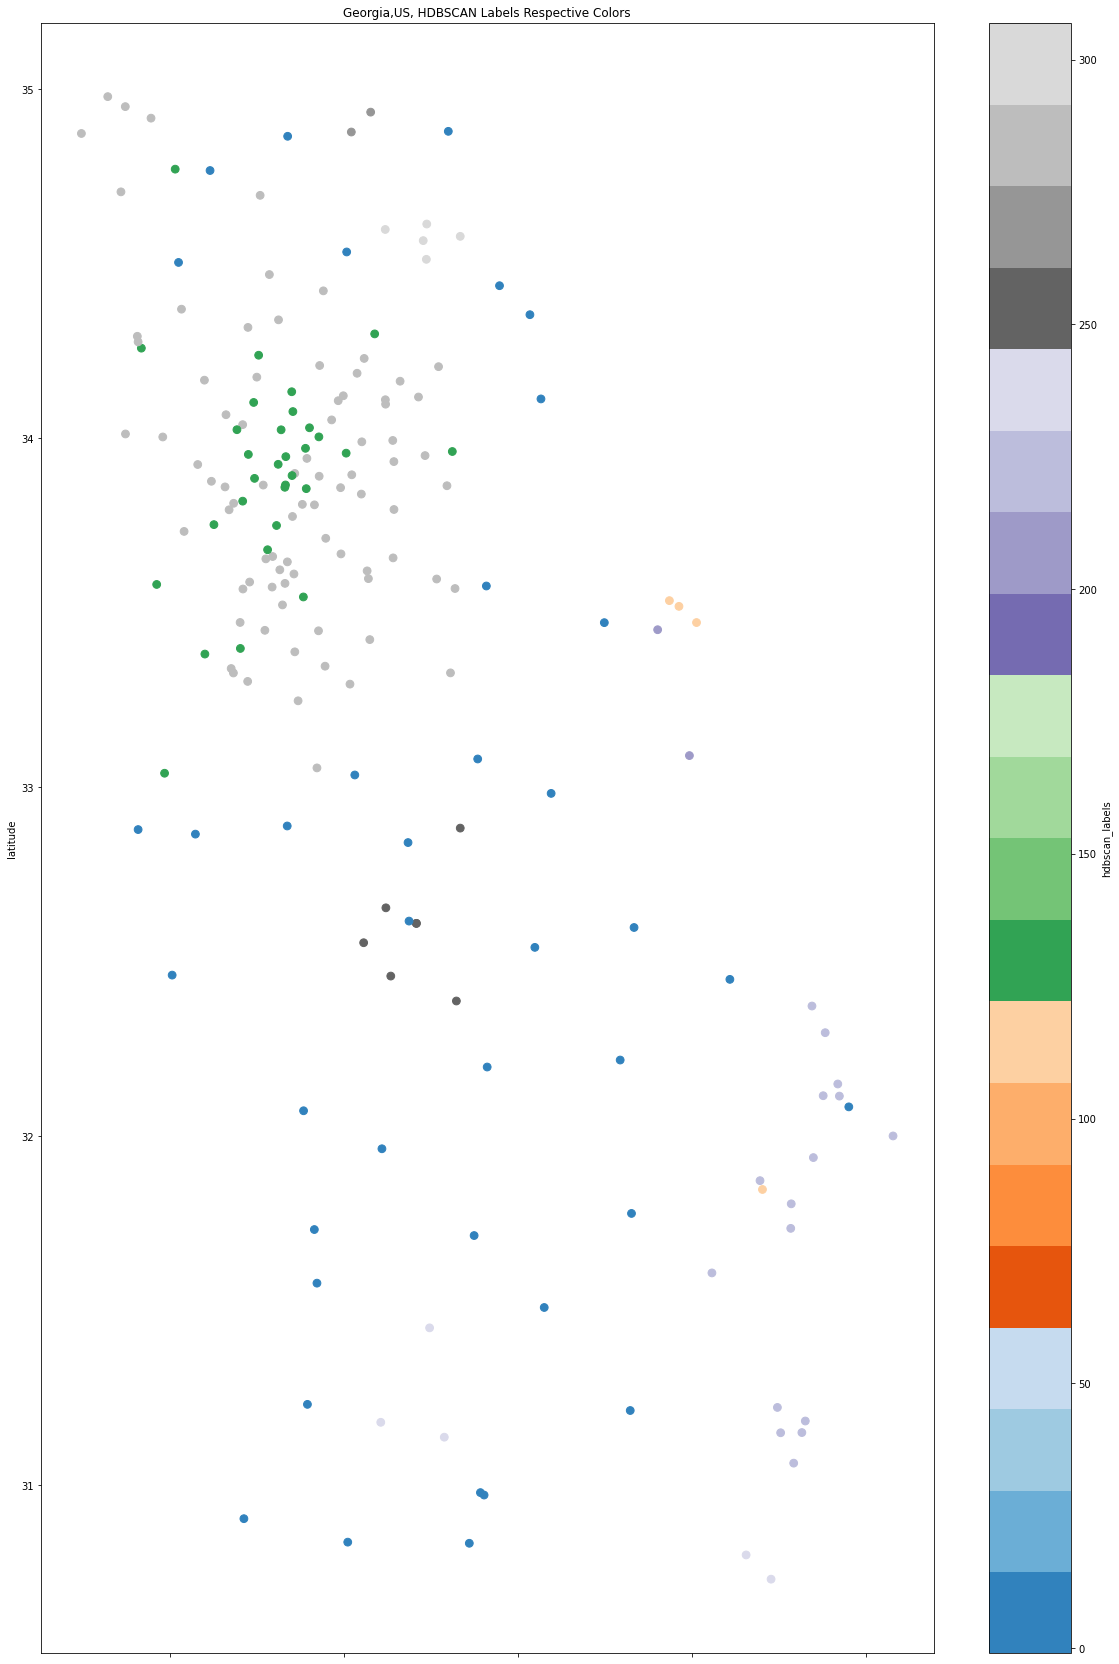

In [70]:
df_us[df_us["state"]=="georgia"].plot(x="longitude", y="latitude", kind="scatter", c="hdbscan_labels", s=60, colormap="tab20c", 
        title= "Georgia,US, HDBSCAN Labels Respective Colors", colorbar=True, figsize=(20,30))
plt.show()

### U.S. Based implementation of HDBSCAN shows reasonably sound segmentation, including detection of outliers. Also, further analysis has been conducted for sample cases of New York and Georgia. Clustering in these states provides a high degree of granularity, so this approach can serve clients who require in-depth analysis within metropolitan areas. Hyperparameter optimization of HDBSCAN allows decreasing the granularity and grouping similar and close clusters.

### Now, methodology will be scaled to worldwide.

In [71]:
df["bins"] = df.groupby("state")["population"].apply(lambda x: 
                                                     pd.cut(x, 
                                                            bins = [0,25000,50000, 100000, 250000, 500000, max(df_us["population"])],
                                                            labels = [0,1,2,2,1,0], ordered =  False, include_lowest = True,
                                                            duplicates='drop'))


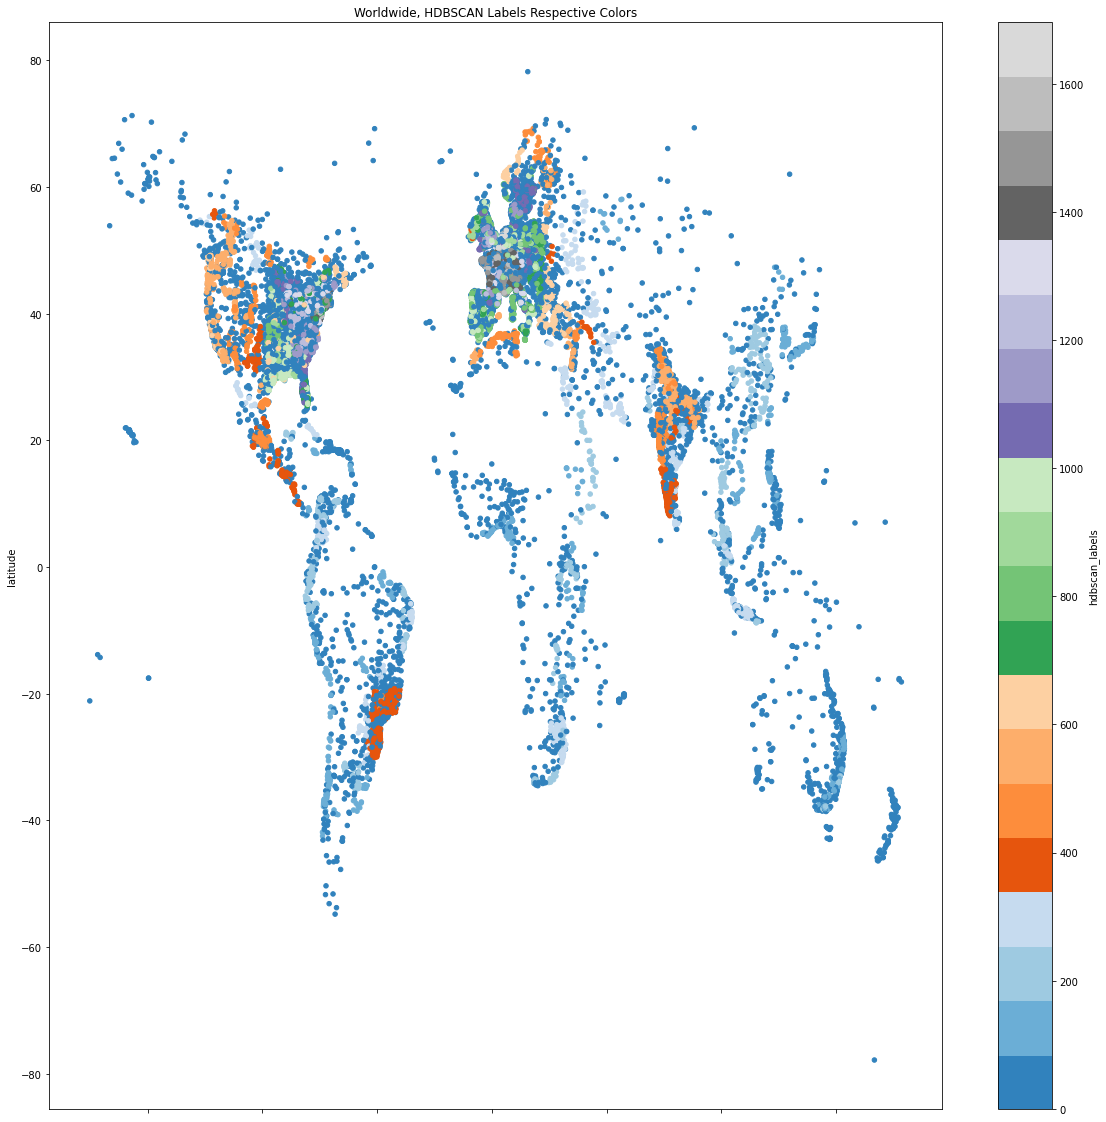

In [72]:
hdb = hdbscan.HDBSCAN(min_cluster_size=3, cluster_selection_epsilon = 0.015, gen_min_span_tree=True) #metric='haversine',
hdb.fit(df[["latitude", "longitude", "bins"]]) #, "bins"
y_pred = hdb.fit_predict(df[["latitude", "longitude", "bins"]]) #, "bins"
df["hdbscan_labels"] = y_pred
df.plot(x="longitude", y="latitude", kind="scatter", c="hdbscan_labels", s=20, colormap="tab20c", 
        title= "Worldwide, HDBSCAN Labels Respective Colors", colorbar=True, figsize=(20,20))
plt.show()


In [ ]:
# In depth observation of European Cities
#lat33, lon-19 ; 57, 45

df_europe = df.loc[((df["latitude"]>33) & (df["latitude"]<57)) & ((df["longitude"]>-19) & (df["longitude"]<45))].copy()

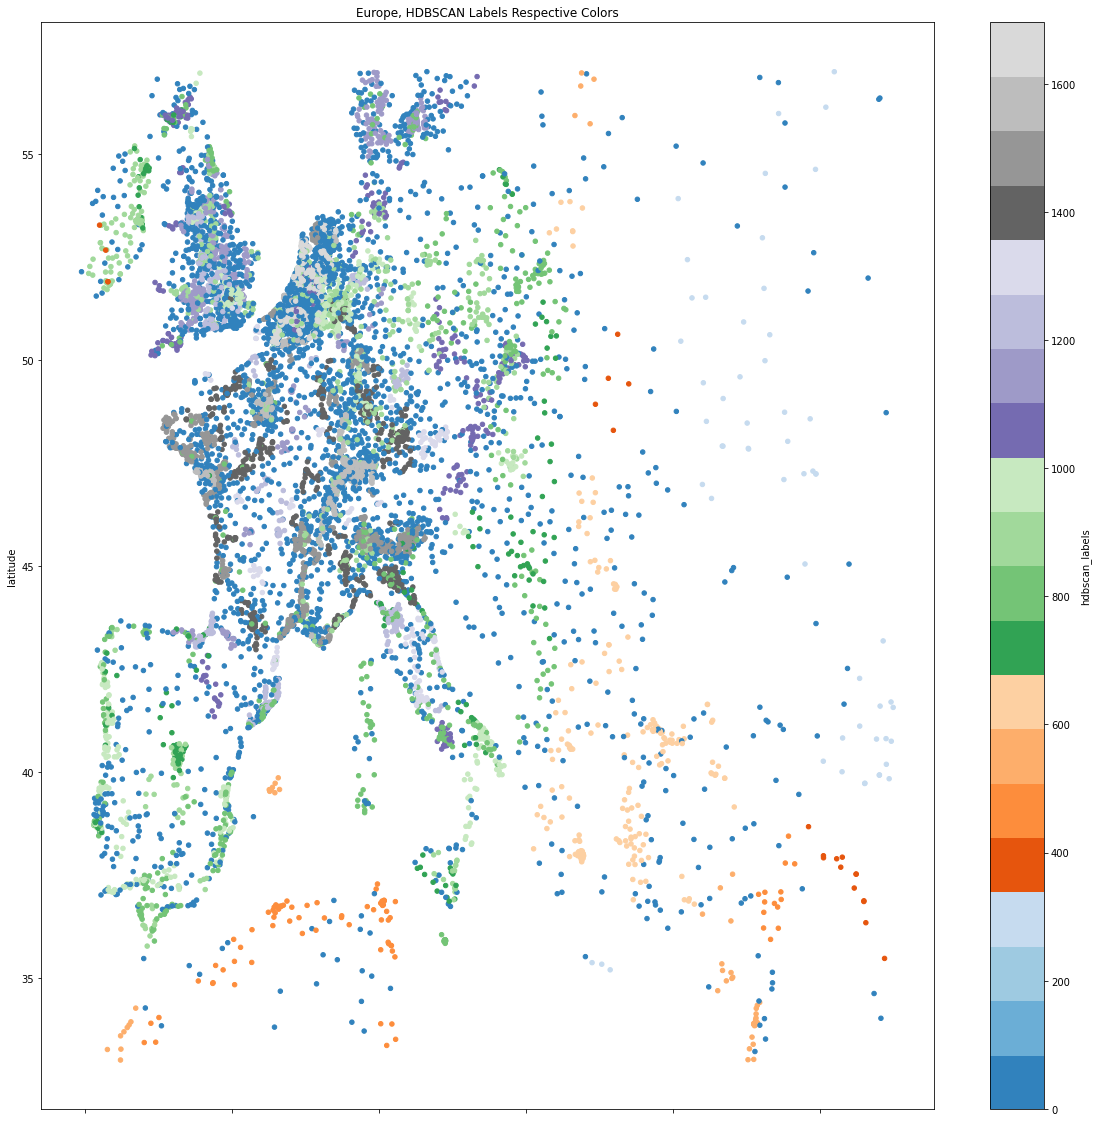

In [ ]:
df_europe.plot(x="longitude", y="latitude", kind="scatter", c="hdbscan_labels", s=20, colormap="tab20c", 
        title= "Europe, HDBSCAN Labels Respective Colors", colorbar=True, figsize=(20,20))
plt.show()


## Caveats of the worldwide application are: 
1. In neighbor countries, cities are clustered together, which may not be reasonable for many boarders. 
2. Current dataset is limited in terms of geographical granularity. For example in Turkey, there are +900 cities (districts) while in the dataset, only 200 are present. This proposes a challenge to find hubs or core cities in the worldwide view.
3. When a sea is present in between countries, distance calculation is not taking land or sea presence into account. Geographiccally, it's not possible for these regions to be in the same metropolitan area.

##### As the next step, clustering will be applied within each country and in this manner, boarders will be taken into account to build a further realistic model.

In [73]:
df.head()

city             state        country  latitude  longitude  \
0           mahopac          new york  united states  41.37232  -73.73346   
1       seven hills              ohio  united states  41.39533  -81.67624   
2  new martinsville     west virginia  united states  39.64452  -80.85760   
3     sint anthonis     north brabant    netherlands  51.62667    5.88194   
4           machali  o higgins region          chile -34.18082  -70.64933   

   population                                                msa  \
0        8369  New York-Northern New Jersey-Long Island NY-NJ...   
1       11690                                                NaN   
2        5218                            WV NONMETROPOLITAN AREA   
3        3340                                                NaN   
4       27595                                                NaN   

  categorical_state  categorical_state_codes bins  hdbscan_labels  
0          new york                     1282    0              -1  
1              ohio                     1369    0            1351  
2     west virginia                     2074    0              -1  
3     north brabant                     1313    0            1696  
4  o higgins region                     1360    1             160

In [74]:
# Resulting Clusters are identified with hdbscan_labels column. -1 represents outliers.
# Below dataset presents clustering results without boarders.
df.to_csv("furkan_oruc_results_reveliolabs_boarderless.csv")

In [23]:
import hdbscan
def hdbscan_application(df):
  hdb = hdbscan.HDBSCAN(min_cluster_size=2, cluster_selection_epsilon = 0.015, gen_min_span_tree=True) #metric='haversine',
  hdb.fit(df[["latitude", "longitude", "bins"]]) #, "bins"
  y_pred = hdb.fit_predict(df[["latitude", "longitude", "bins"]]) #, "bins"
  return y_pred


In [44]:
# Dropping countries with less than 2 cities

sub_df = df[df.groupby('country').country.transform('count')>=5].copy() 
sub_df = sub_df.dropna(axis=0, subset = ["longitude","latitude","bins"])
sub_df.reset_index(inplace = True)

In [49]:
g = sub_df.groupby('country')
sub_df['country_id'] = g.ngroup()
x = sub_df.groupby('country').apply(hdbscan_application).droplevel(0)
x

0    -1
1    -1
2    -1
3    -1
4    -1
     ..
14   -1
15   -1
16   -1
17    1
18    0
Length: 25219, dtype: int64

In [55]:
#x=x.reset_index()
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25219 entries, 0 to 25218
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   level_0  25219 non-null  int64
 1   index    25219 non-null  int64
 2   0        25219 non-null  int64
dtypes: int64(3)
memory usage: 591.2 KB


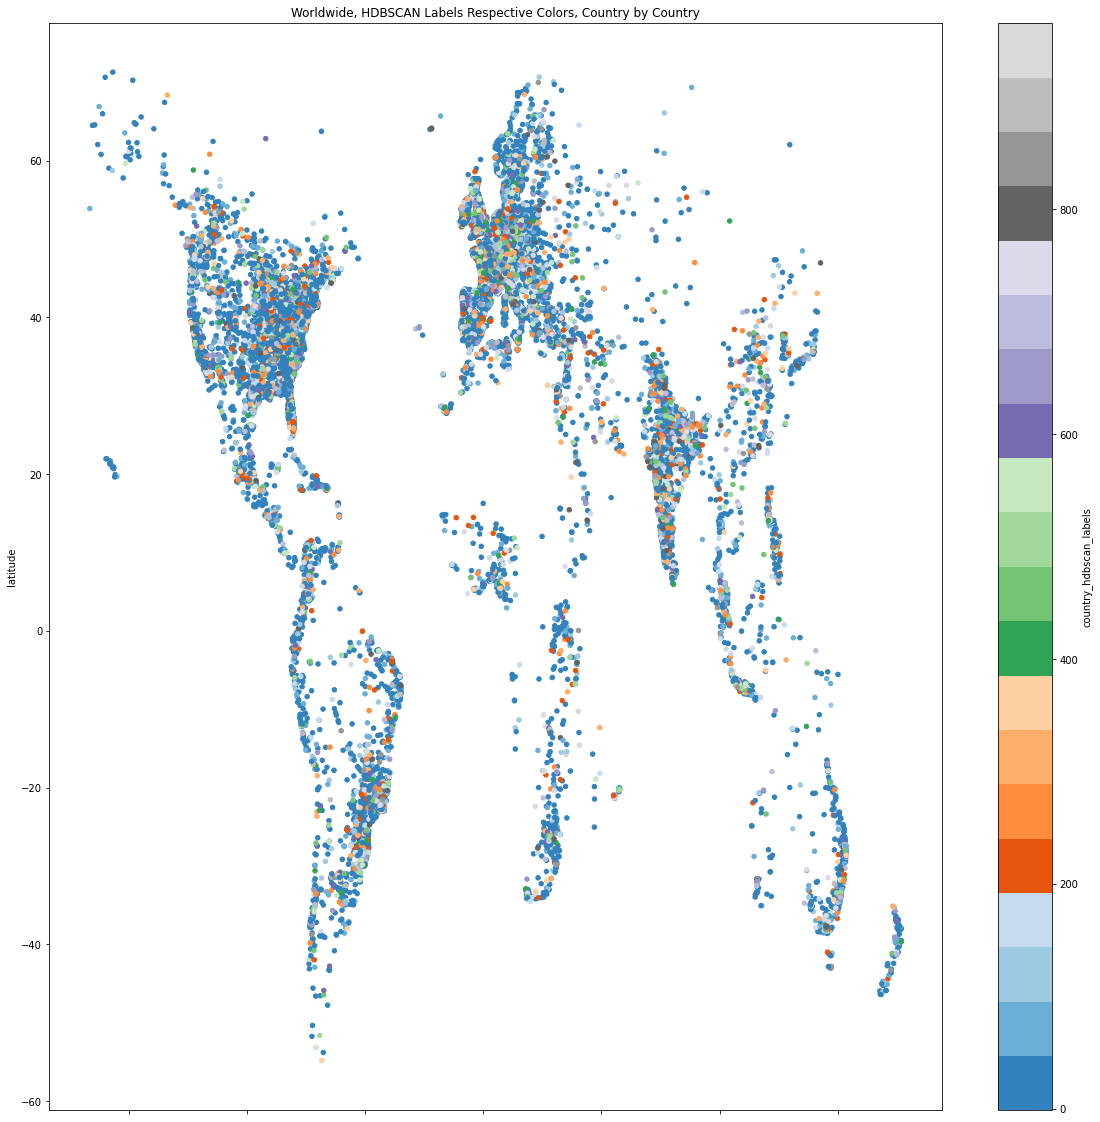

In [58]:
g = sub_df.groupby('country')
sub_df['country_id'] = g.ngroup()
x = sub_df.groupby('country').apply(hdbscan_application).droplevel(0)
x=x.reset_index(drop=True)
sub_df['country_hdbscan_labels'] = x #.reindex()
sub_df = sub_df.drop(columns=['country_id'])

sub_df.plot(x="longitude", y="latitude", kind="scatter", c="country_hdbscan_labels", s=20, colormap="tab20c", 
        title= "Worldwide, HDBSCAN Labels Respective Colors, Country by Country", colorbar=True, figsize=(20,20))
plt.show()


In [59]:
# In depth observation for European Cities only, within Country group clustering

sub_df_europe = sub_df.loc[((sub_df["latitude"]>33) & (sub_df["latitude"]<57)) & 
                           ((sub_df["longitude"]>-19) & (sub_df["longitude"]<45))].copy()

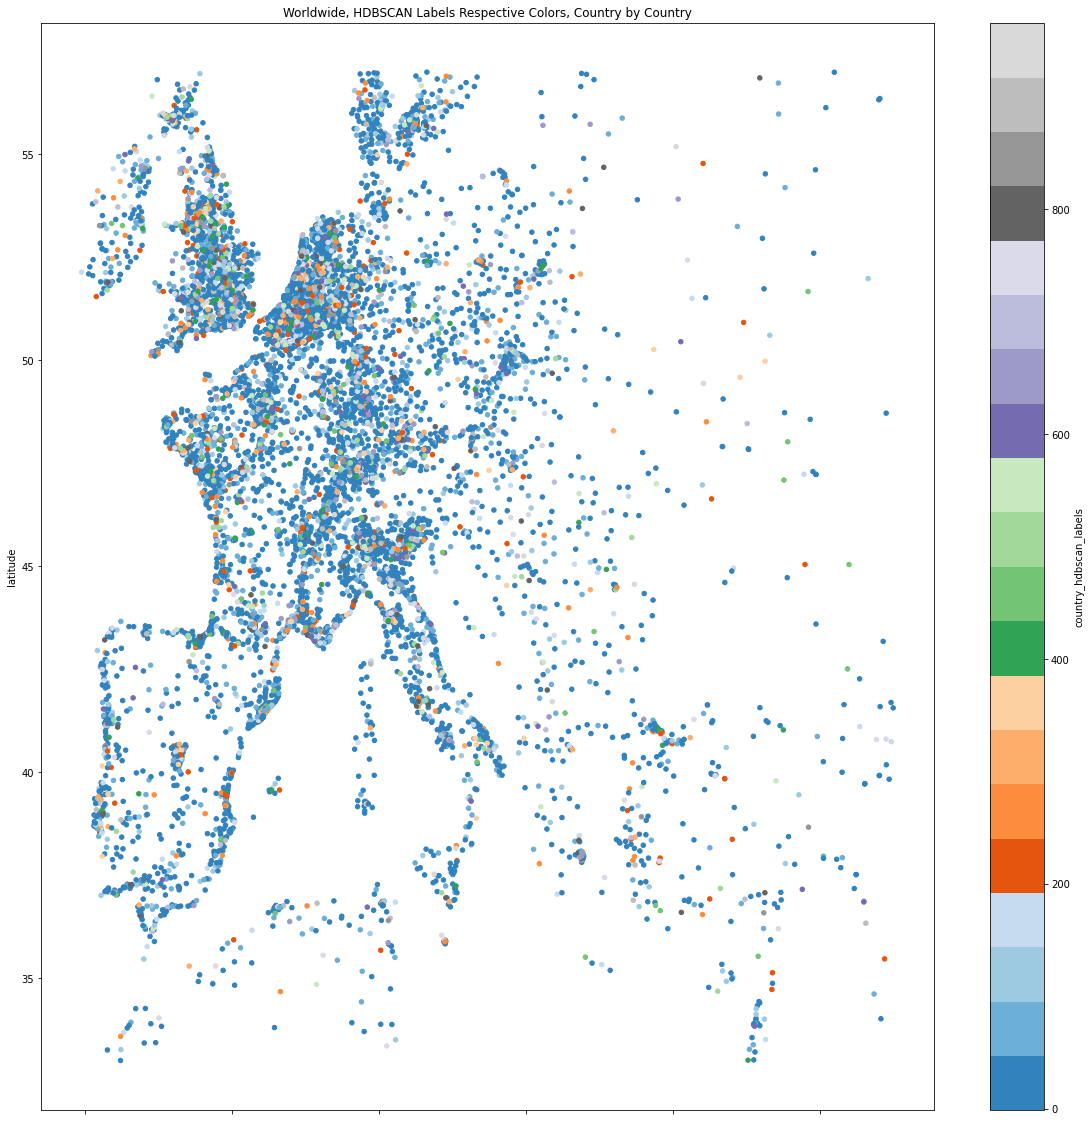

In [61]:
sub_df_europe.plot(x="longitude", y="latitude", kind="scatter", c="country_hdbscan_labels", s=20, colormap="tab20c", 
        title= "Worldwide, HDBSCAN Labels Respective Colors, Country by Country", colorbar=True, figsize=(20,20))
plt.show()

### Above, within country HDBSCAN clustering is presented to take boarders of the neighbor countries into account. When compared with general worldwide clustering, more outliers are produced with this method.

In [75]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25219 entries, 0 to 25218
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   index                    25219 non-null  int64   
 1   city                     25219 non-null  object  
 2   state                    25219 non-null  object  
 3   country                  25219 non-null  object  
 4   latitude                 25219 non-null  float64 
 5   longitude                25219 non-null  float64 
 6   population               25219 non-null  int64   
 7   msa                      7024 non-null   object  
 8   categorical_state        25219 non-null  category
 9   categorical_state_codes  25219 non-null  int16   
 10  bins                     25219 non-null  category
 11  country_hdbscan_labels   25219 non-null  int64   
dtypes: category(2), float64(2), int16(1), int64(3), object(4)
memory usage: 1.9+ MB


In [76]:
# Resulting Clusters are identified with country_hdbscan_labels column. "-1" represents outliers.
# Below dataset presents clustering results with respect to boarders. Each country is clustered within itself.
sub_df.to_csv("furkan_oruc_results_reveliolabs_with_boarders.csv")